# <font color="red">Icon Prediction with Light GBM Classifier</font>

# Import Library

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import json
from contextlib import redirect_stdout, redirect_stderr
import io

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier

import sys
sys.path.append('../../') # Uncomment this line if running locally
# sys.path.append('/kaggle/input/weatherdata') # Uncomment this line if running on Kaggle
from historyManagement import *

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Datasets Import

In [2]:
# Load the weather dataset for visibility prediction
weather_data = pd.read_csv('../../FinalDatasets/finalDataset.csv') # Uncomment this line if running locally
# weather_data = pd.read_csv('/kaggle/input/weatherdata/finalDataset.csv') # Uncomment this line if running on Kaggl
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime'])
weather_data.head()

DateTime  Year  Month  Day  Hour DaySegments  \
0 2023-01-01 00:00:00  2023      1    1     0  Late Night   
1 2023-01-01 01:00:00  2023      1    1     1  Late Night   
2 2023-01-01 02:00:00  2023      1    1     2  Late Night   
3 2023-01-01 03:00:00  2023      1    1     3  Late Night   
4 2023-01-01 04:00:00  2023      1    1     4  Late Night   

   DaySegments_Afternoon  DaySegments_Early Morning  DaySegments_Evening  \
0                      0                          0                    0   
1                      0                          0                    0   
2                      0                          0                    0   
3                      0                          0                    0   
4                      0                          0                    0   

   DaySegments_Late Night  ...  WindDir  SeaLevelPressure  CloudCover  \
0                       1  ...     0.49           1018.68        0.03   
1                       1  ...     0.54           1018.03        0.11   
2                       1  ...    30.51           1017.56        0.03   
3                       1  ...    49.23           1018.05        0.00   
4                       1  ...    49.90           1018.00       86.17   

   UVIndex  SevereRisk  Visibility  SolarRadiation SolarEnergy  \
0      0.0        10.0        2.76             0.0         0.0   
1      0.0        10.0        1.75             0.0         0.0   
2      0.0        10.0        1.75             0.0         0.0   
3      0.0        10.0        2.28             0.0         0.0   
4      0.0        10.0        1.27             0.0         0.0   

         Conditions         Icon  
0             Clear  clear-night  
1             Clear  clear-night  
2             Clear  clear-night  
3             Clear  clear-night  
4  Partially cloudy          fog  

[5 rows x 36 columns]

In [3]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

In [4]:
weather_data.describe()

DateTime          Year         Month           Day  \
count                14616  14616.000000  14616.000000  14616.000000   
mean   2023-11-01 11:30:00   2023.400657      5.720854     15.735632   
min    2023-01-01 00:00:00   2023.000000      1.000000      1.000000   
25%    2023-06-02 05:45:00   2023.000000      3.000000      8.000000   
50%    2023-11-01 11:30:00   2023.000000      6.000000     16.000000   
75%    2024-04-01 17:15:00   2024.000000      8.000000     23.000000   
max    2024-08-31 23:00:00   2024.000000     12.000000     31.000000   
std                    NaN      0.490048      3.195073      8.803610   

               Hour  DaySegments_Afternoon  DaySegments_Early Morning  \
count  14616.000000           14616.000000               14616.000000   
mean      11.500000               0.131294                   0.060550   
min        0.000000               0.000000                   0.000000   
25%        5.750000               0.000000                   0.000000   
50%       11.500000               0.000000                   0.000000   
75%       17.250000               0.000000                   0.000000   
max       23.000000               1.000000                   1.000000   
std        6.922423               0.337734                   0.238511   

       DaySegments_Evening  DaySegments_Late Night  DaySegments_Midday  ...  \
count         14616.000000            14616.000000        14616.000000  ...   
mean              0.098043                0.249726            0.116585  ...   
min               0.000000                0.000000            0.000000  ...   
25%               0.000000                0.000000            0.000000  ...   
50%               0.000000                0.000000            0.000000  ...   
75%               0.000000                0.000000            0.000000  ...   
max               1.000000                1.000000            1.000000  ...   
std               0.297383                0.432869            0.320936  ...   

           Windgust     WindSpeed       WindDir  SeaLevelPressure  \
count  14616.000000  14616.000000  14616.000000      14616.000000   
mean      17.068560      8.090783    159.739178       1008.265012   
min        0.660000      0.000000      0.000000        982.420000   
25%        9.170000      2.870000     80.965000       1003.277500   
50%       14.645000      7.670000    163.790000       1007.970000   
75%       23.410000     11.750000    241.402500       1013.400000   
max       84.120000     71.970000    360.000000       1022.060000   
std       10.195911      6.250203    104.422027          6.010683   

         CloudCover       UVIndex    SevereRisk    Visibility  SolarRadiation  \
count  14616.000000  14616.000000  14616.000000  14616.000000    14616.000000   
mean      53.579923      2.263555     16.504787      4.368134      227.640683   
min        0.000000      0.000000      3.000000      0.000000        0.000000   
25%       26.670000      0.000000     10.000000      3.990000        0.000000   
50%       51.540000      0.000000     10.000000      4.650000       10.665000   
75%       87.790000      4.740000     12.580000      4.650000      459.745000   
max      100.000000     10.000000     97.740000     24.100000     1026.650000   
std       35.166637      3.083074     15.031827      1.376994      307.219387   

        SolarEnergy  
count  14616.000000  
mean       0.819217  
min        0.000000  
25%        0.000000  
50%        0.010000  
75%        1.660000  
max        3.700000  
std        1.106444  

[8 rows x 32 columns]

# Data Split

In [5]:
# Remove classes with only 1 sample to satisfy StratifiedShuffleSplit requirements
icon_counts = weather_data['Icon'].value_counts()
valid_icons = icon_counts[icon_counts > 1].index
weather_data_filtered = weather_data[weather_data['Icon'].isin(valid_icons)]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(weather_data_filtered, weather_data_filtered['Icon']):
    weather_data_train = weather_data_filtered.iloc[train_idx]
    weather_data_test = weather_data_filtered.iloc[test_idx]

In [6]:
# Show the count of each unique class in Icon
class_counts = weather_data['Icon'].value_counts().reset_index()
class_counts.columns = ['Icon', 'Count']

print("Distribution of data based on Icon:")
print(class_counts)

Distribution of data based on Icon:
                  Icon  Count
0  partly-cloudy-night   3901
1    partly-cloudy-day   3869
2                 rain   2886
3          clear-night   1811
4            clear-day   1505
5               cloudy    623
6                  fog     20
7                 wind      1


In [7]:
# Show the count of each unique class in Icon
class_counts = weather_data_filtered['Icon'].value_counts().reset_index()
class_counts.columns = ['Icon', 'Count']

print("Distribution of data based on Icon:")
print(class_counts)

Distribution of data based on Icon:
                  Icon  Count
0  partly-cloudy-night   3901
1    partly-cloudy-day   3869
2                 rain   2886
3          clear-night   1811
4            clear-day   1505
5               cloudy    623
6                  fog     20


In [8]:
print("Distribution of Icon in Training Set:")
print(weather_data_train['Icon'].value_counts())

print("\nDistribution of Icon in Test Set:")
print(weather_data_test['Icon'].value_counts())

Distribution of Icon in Training Set:
Icon
partly-cloudy-night    3121
partly-cloudy-day      3095
rain                   2309
clear-night            1449
clear-day              1204
cloudy                  498
fog                      16
Name: count, dtype: int64

Distribution of Icon in Test Set:
Icon
partly-cloudy-night    780
partly-cloudy-day      774
rain                   577
clear-night            362
clear-day              301
cloudy                 125
fog                      4
Name: count, dtype: int64


# Some Reused Parameters

In [9]:
grid_param = {
    'max_depth': [-1, 3, 5, 7, 10],
    'num_leaves': [31, 50, 100, 150, 200],
    'min_child_samples': [20, 50, 100, 200],
    'min_child_weight': [0.001, 0.01, 0.1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'bagging_freq': [0, 1, 5],
    'min_split_gain': [0.0, 0.1, 0.2],
    'subsample_for_bin': [200000, 300000, 500000]
}

In [10]:
number_of_model_for_randomized_grid = 350
model_name_for_saving = "Light GBM"
target_name_for_saving = "Icon"
number_of_model_for_bagging = 100

# All Features

In [11]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_train = weather_data_train['Icon']

In [12]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_test = weather_data_test['Icon']

In [13]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [14]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2923
y_test:  2923


## MinMax Scaler

In [15]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert back to DataFrame to preserve feature names
X_train = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

# Clean column names - replace spaces with underscores
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [16]:
X_train

Month       Day      Hour  DaySegments_Afternoon  \
0      0.454545  0.200000  0.043478                    0.0   
1      0.454545  0.800000  0.826087                    0.0   
2      0.636364  0.900000  0.869565                    0.0   
3      0.454545  0.800000  0.913043                    0.0   
4      0.454545  0.133333  0.000000                    0.0   
...         ...       ...       ...                    ...   
11687  0.818182  0.900000  0.478261                    0.0   
11688  0.545455  0.933333  0.739130                    1.0   
11689  0.545455  0.666667  0.130435                    0.0   
11690  0.454545  0.333333  0.478261                    0.0   
11691  0.545455  0.100000  0.391304                    0.0   

       DaySegments_Early_Morning  DaySegments_Evening  DaySegments_Late_Night  \
0                            0.0                  0.0                     1.0   
1                            0.0                  1.0                     0.0   
2                            0.0                  1.0                     0.0   
3                            0.0                  0.0                     0.0   
4                            0.0                  0.0                     1.0   
...                          ...                  ...                     ...   
11687                        0.0                  0.0                     0.0   
11688                        0.0                  0.0                     0.0   
11689                        0.0                  0.0                     1.0   
11690                        0.0                  0.0                     0.0   
11691                        0.0                  0.0                     0.0   

       DaySegments_Midday  DaySegments_Morning  DaySegments_Night  ...  \
0                     0.0                  0.0                0.0  ...   
1                     0.0                  0.0                0.0  ...   
2                     0.0                  0.0                0.0  ...   
3                     0.0                  0.0                1.0  ...   
4                     0.0                  0.0                0.0  ...   
...                   ...                  ...                ...  ...   
11687                 0.0                  1.0                0.0  ...   
11688                 0.0                  0.0                0.0  ...   
11689                 0.0                  0.0                0.0  ...   
11690                 0.0                  1.0                0.0  ...   
11691                 0.0                  1.0                0.0  ...   

       Humidity    Precip  PrecipProb  Windgust  WindSpeed   WindDir  \
0      0.859737  0.000449      0.0645  0.260319   0.156364  0.275361   
1      0.599814  0.000000      0.0000  0.365762   0.449980  0.410389   
2      0.863113  0.000225      0.0968  0.142092   0.110817  0.397944   
3      0.628332  0.000000      0.0000  0.401802   0.148231  0.245528   
4      0.608311  0.000000      0.0000  0.311457   0.090484  0.435722   
...         ...       ...         ...       ...        ...       ...   
11687  0.463974  0.000000      0.0000  0.144649   0.258438  0.060389   
11688  0.701315  0.001798      0.8065  0.297821   0.364376  0.384417   
11689  0.809219  0.002022      0.8710  0.421527   0.337739  0.357806   
11690  0.662787  0.000000      0.0000  0.205406   0.191135  0.411278   
11691  0.905715  0.024045      0.9677  0.371850   0.189711  0.442833   

       SeaLevelPressure  CloudCover  UVIndex  SevereRisk  
0              0.518416      0.4839    0.000    0.275807  
1              0.479062      0.7139    0.000    0.073886  
2              0.543643      0.5161    0.000    0.101119  
3              0.529263      0.7464    0.000    0.073886  
4              0.544904      0.2806    0.000    0.002428  
...                 ...         ...      ...         ...  
11687          0.797427      0.0000    0.797    0.073886  
11688          0.366044      0.8779    0.206    0.284991  
11689  

In [17]:
X_test

Month       Day      Hour  DaySegments_Afternoon  \
0     0.818182  1.000000  0.043478                    0.0   
1     0.363636  0.333333  0.130435                    0.0   
2     0.636364  0.633333  0.652174                    1.0   
3     0.181818  0.233333  0.130435                    0.0   
4     0.636364  0.966667  0.565217                    0.0   
...        ...       ...       ...                    ...   
2918  0.818182  0.300000  0.043478                    0.0   
2919  0.909091  0.633333  0.217391                    0.0   
2920  0.636364  0.133333  0.130435                    0.0   
2921  0.909091  0.400000  0.608696                    1.0   
2922  0.636364  0.233333  0.478261                    0.0   

      DaySegments_Early_Morning  DaySegments_Evening  DaySegments_Late_Night  \
0                           0.0                  0.0                     1.0   
1                           0.0                  0.0                     1.0   
2                           0.0                  0.0                     0.0   
3                           0.0                  0.0                     1.0   
4                           0.0                  0.0                     0.0   
...                         ...                  ...                     ...   
2918                        0.0                  0.0                     1.0   
2919                        1.0                  0.0                     0.0   
2920                        0.0                  0.0                     1.0   
2921                        0.0                  0.0                     0.0   
2922                        0.0                  0.0                     0.0   

      DaySegments_Midday  DaySegments_Morning  DaySegments_Night  ...  \
0                    0.0                  0.0                0.0  ...   
1                    0.0                  0.0                0.0  ...   
2                    0.0                  0.0                0.0  ...   
3                    0.0                  0.0                0.0  ...   
4                    1.0                  0.0                0.0  ...   
...                  ...                  ...                ...  ...   
2918                 0.0                  0.0                0.0  ...   
2919                 0.0                  0.0                0.0  ...   
2920                 0.0                  0.0                0.0  ...   
2921                 0.0                  0.0                0.0  ...   
2922                 0.0                  1.0                0.0  ...   

      Humidity    Precip  PrecipProb  Windgust  WindSpeed   WindDir  \
0     0.693400  0.000000      0.0000  0.048216   0.003253  0.002306   
1     0.759283  0.011011      0.9032  0.091319   0.047174  0.109333   
2     0.659993  0.023820      0.9677  0.201266   0.199675  0.511833   
3     0.496915  0.000000      0.0000  0.097041   0.007523  0.960750   
4     0.452567  0.000000      0.0000  0.057957   0.081537  0.052889   
...        ...       ...         ...       ...        ...       ...   
2918  0.729950  0.000000      0.0000  0.125046   0.000813  0.010056   
2919  0.773600  0.000000      0.0000  0.063071   0.005693  0.028194   
2920  0.809335  0.028539      0.9677  0.265555   0.112241  0.517806   
2921  0.332557  0.000000      0.0000  0.078169   0.173038  0.146583   
2922  0.818764  0.003820      1.0000  0.296238   0.367019  0.661278   

      SeaLevelPressure  CloudCover  UVIndex  SevereRisk  
0             0.796670      0.0323    0.000    0.073886  
1             0.683653      0.4920    0.000    0.064387  
2             0.504793      0.8467    0.490    0.257758  
3             0.750757      0.0000    0.000    0.073886  
4             0.532543      0.4951    0.900    0.073886  
...                ...         ...      ...         ...  
2918          0.669778      0.4839    0.000    0.242453  
2919          0.797427      0.4839    0.000    0.073886  
2920          0.562059      0.5704    0.000    0.073886  
2921 

### Default Parameters

In [18]:
training_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
training_model

LGBMClassifier(force_col_wise=True, objective='multiclass', random_state=42,
               verbose=0)

In [19]:
%%time
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    training_model.fit(X_train, y_train)

CPU times: total: 2.75 s
Wall time: 2.43 s


In [20]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'clear-day', 'partly-cloudy-day', ..., 'rain',
       'partly-cloudy-day', 'rain'], shape=(2923,), dtype=object)

In [21]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [22]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [23]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.6107
Precision: 0.6202
Recall:    0.6107
F1-Score:  0.5647


In [24]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.00      0.00      0.00       301
        clear-night       0.89      0.40      0.55       362
             cloudy       0.14      0.09      0.11       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.55      0.91      0.69       774
partly-cloudy-night       0.68      0.92      0.78       780
               rain       0.90      0.36      0.52       577

           accuracy                           0.61      2923
          macro avg       0.45      0.38      0.38      2923
       weighted avg       0.62      0.61      0.56      2923



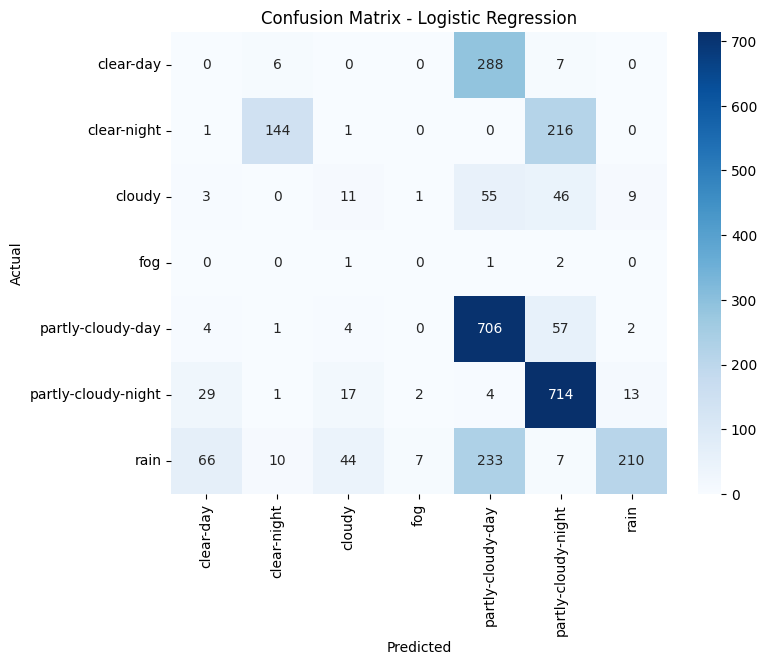

In [25]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [26]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [27]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [28]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.4794
clear-night : 0.6980
cloudy   : 0.5310
fog      : 0.4979
partly-cloudy-day : 0.8209
partly-cloudy-night : 0.8800
rain     : 0.6872
Micro-avg : 0.7751


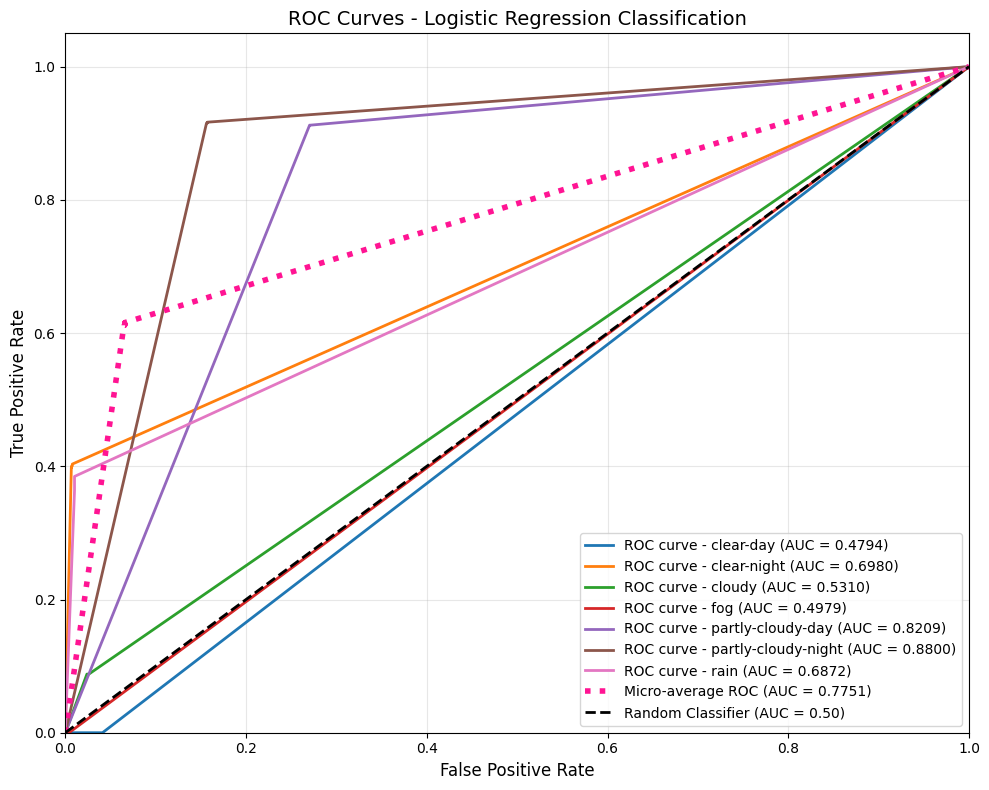

In [29]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.7470
One-vs-One (Weighted)  : 0.6819
Micro-average          : 0.7751


In [31]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.610674, F1: 0.564688, AUC (micro-avg): 0.775093
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [32]:
grid_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass'), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_col_wise=True,
                                            objective='multiclass',
                                            random_state=42, verbose=0),
                   n_iter=350, n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.8, 0.9, 1.0],
                                        'bagging_freq': [0, 1, 5],
                                        'feature_fraction': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [-1, 3, 5, 7, 10],
                                        'min_child_samples': [20, 50, 100, 200],
                                        'min_child_weight': [0.001, 0.01, 0.1],
                                        'min_split_gain': [0.0, 0.1, 0.2],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [31, 50, 100, 150, 200],
                                        'reg_alpha': [0.0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0.0, 0.1, 0.5, 1.0],
                                        'subsample_for_bin': [200000, 300000,
                                                              500000]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [33]:
%%time
print("Starting Grid Search...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    grid_search.fit(X_train, y_train)

Starting Grid Search...
CPU times: total: 15.7 s
Wall time: 20min 3s


In [34]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'subsample_for_bin': 200000, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 300, 'min_split_gain': 0.2, 'min_child_weight': 0.1, 'min_child_samples': 200, 'max_depth': 5, 'learning_rate': 0.2, 'feature_fraction': 0.9, 'bagging_freq': 1, 'bagging_fraction': 0.9}
Best Cross-Validation Score: 0.9912177186471991


In [35]:
y_pred_grid = best_grid_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [36]:
y_pred_grid

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], shape=(2923,), dtype=object)

In [37]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [38]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [39]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9904
Precision: 0.9891
Recall:    0.9904
F1-Score:  0.9897


In [40]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.98      0.99       301
        clear-night       1.00      0.98      0.99       362
             cloudy       0.96      0.98      0.97       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



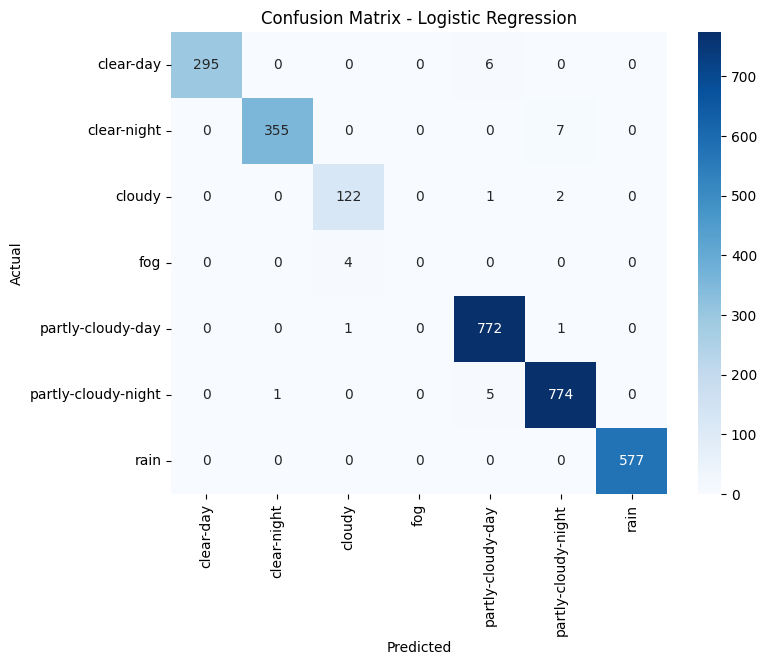

In [41]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [43]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [44]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 1.0000
cloudy   : 0.9957
fog      : 0.9621
partly-cloudy-day : 0.9997
partly-cloudy-night : 0.9999
rain     : 1.0000
Micro-avg : 0.9995


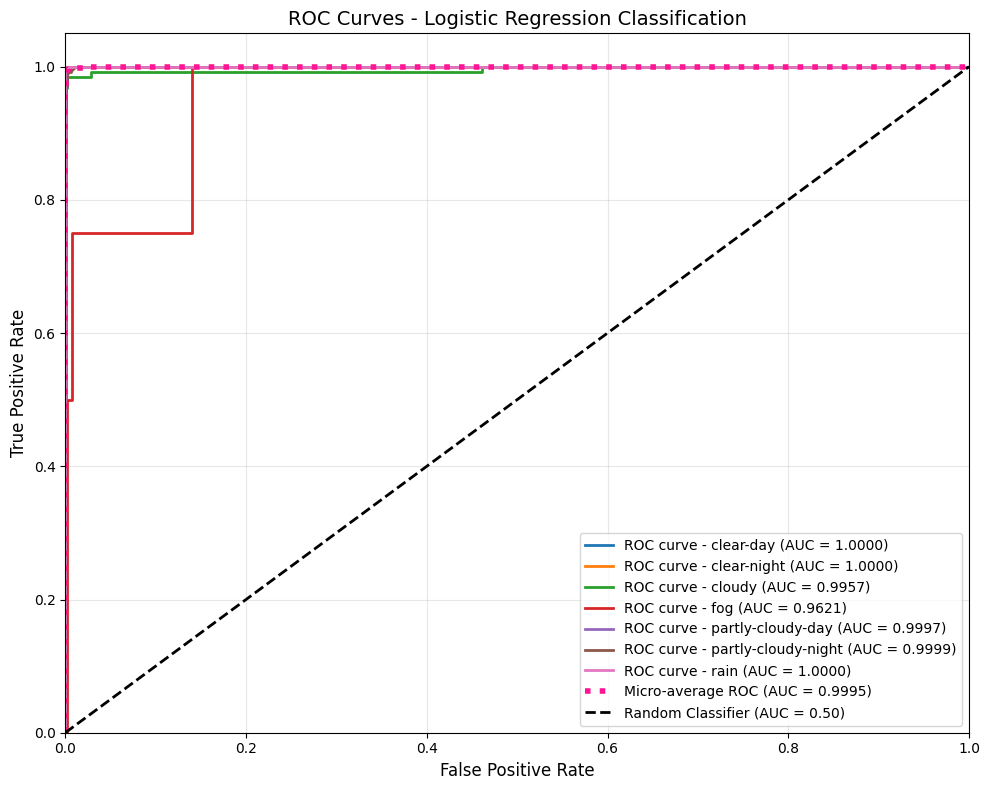

In [45]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [46]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9997
One-vs-One (Weighted)  : 0.9953
Micro-average          : 0.9995


In [47]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.990421, F1: 0.989748, AUC (micro-avg): 0.999519
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [48]:
base_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
base_model

LGBMClassifier(force_col_wise=True, objective='multiclass', random_state=42,
               verbose=0)

In [49]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=LGBMClassifier(force_col_wise=True,
                                           objective='multiclass',
                                           random_state=42, verbose=0),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [50]:
%%time
print("Starting Bagging Ensemble...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    bagging_clf.fit(X_train, y_train)

Starting Bagging Ensemble...
CPU times: total: 6.03 s
Wall time: 1min 17s


In [51]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.0s remaining:    9.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.2s finished


In [52]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [53]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9891
Precision: 0.9878
Recall:    0.9891
F1-Score:  0.9884


In [54]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.98      0.99       301
        clear-night       1.00      0.97      0.98       362
             cloudy       0.96      0.98      0.97       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      1.00      0.99       774
partly-cloudy-night       0.98      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.84      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



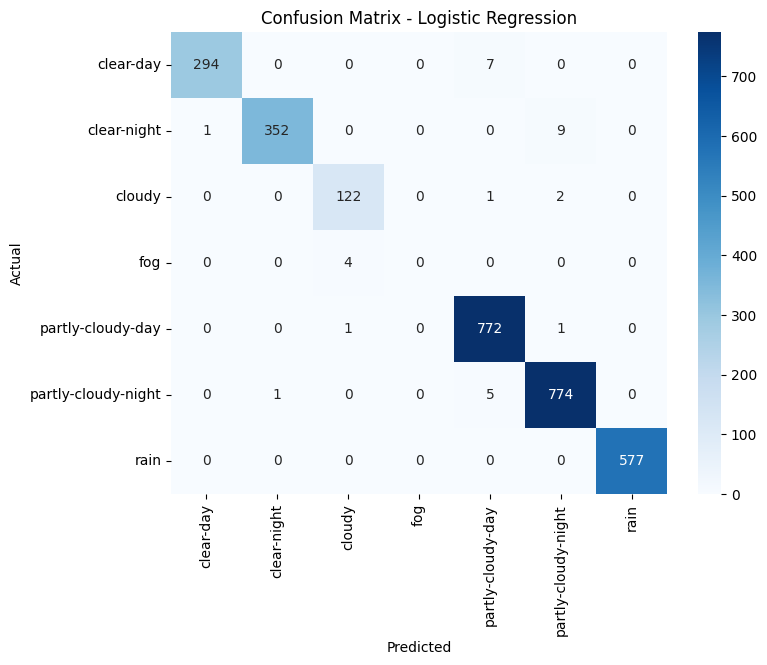

In [55]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [56]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.1s remaining:    9.5s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.3s finished


In [57]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [58]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9997
clear-night : 0.9995
cloudy   : 0.9925
fog      : 0.9964
partly-cloudy-day : 0.9996
partly-cloudy-night : 0.9992
rain     : 1.0000
Micro-avg : 0.9991


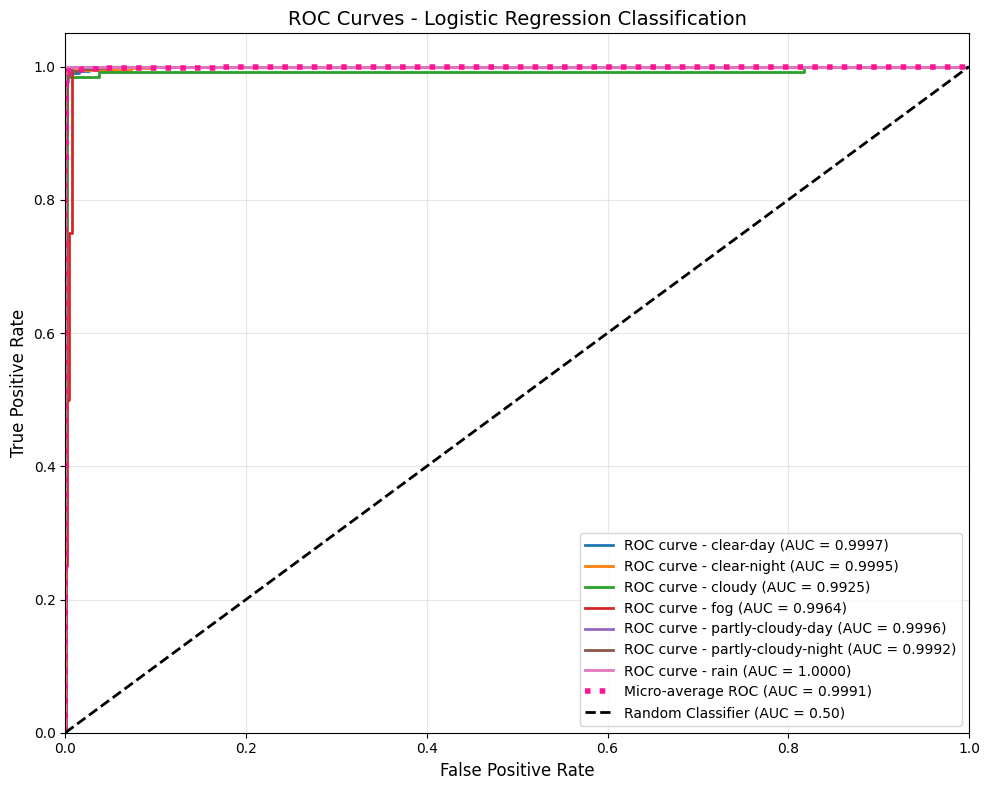

In [59]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [60]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9993
One-vs-One (Weighted)  : 0.9969
Micro-average          : 0.9991


In [61]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.989052, F1: 0.988371, AUC (micro-avg): 0.999093
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Standard Scaler

In [62]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert back to DataFrame to preserve feature names
X_train = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

# Clean column names - replace spaces with underscores
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [63]:
X_train

Month       Day      Hour  DaySegments_Afternoon  \
0      0.088732 -0.994681 -1.517539              -0.388897   
1      0.088732  1.044405  1.075234              -0.388897   
2      0.713519  1.384253  1.219277              -0.388897   
3      0.088732  1.044405  1.363320              -0.388897   
4      0.088732 -1.221247 -1.661582              -0.388897   
...         ...       ...       ...                    ...   
11687  1.338307  1.384253 -0.077110              -0.388897   
11688  0.401126  1.497535  0.787148               2.571377   
11689  0.401126  0.591275 -1.229453              -0.388897   
11690  0.088732 -0.541551 -0.077110              -0.388897   
11691  0.401126 -1.334529 -0.365195              -0.388897   

       DaySegments_Early_Morning  DaySegments_Evening  DaySegments_Late_Night  \
0                      -0.250817            -0.334567                1.730866   
1                      -0.250817             2.988935               -0.577745   
2                      -0.250817             2.988935               -0.577745   
3                      -0.250817            -0.334567               -0.577745   
4                      -0.250817            -0.334567                1.730866   
...                          ...                  ...                     ...   
11687                  -0.250817            -0.334567               -0.577745   
11688                  -0.250817            -0.334567               -0.577745   
11689                  -0.250817            -0.334567                1.730866   
11690                  -0.250817            -0.334567               -0.577745   
11691                  -0.250817            -0.334567               -0.577745   

       DaySegments_Midday  DaySegments_Morning  DaySegments_Night  ...  \
0               -0.360086            -0.559306          -0.343350  ...   
1               -0.360086            -0.559306          -0.343350  ...   
2               -0.360086            -0.559306          -0.343350  ...   
3               -0.360086            -0.559306           2.912484  ...   
4               -0.360086            -0.559306          -0.343350  ...   
...                   ...                  ...                ...  ...   
11687           -0.360086             1.787931          -0.343350  ...   
11688           -0.360086            -0.559306          -0.343350  ...   
11689           -0.360086            -0.559306          -0.343350  ...   
11690           -0.360086             1.787931          -0.343350  ...   
11691           -0.360086             1.787931          -0.343350  ...   

       Humidity    Precip  PrecipProb  Windgust  WindSpeed   WindDir  \
0      1.174694 -0.166971   -0.348147  0.510148  -0.064689 -0.581819   
1     -0.335607 -0.189481   -0.520404  1.362090   2.268828 -0.114821   
2      1.194308 -0.178226   -0.261884 -0.445089  -0.426675 -0.157860   
3     -0.169900 -0.189481   -0.520404  1.653285  -0.129329 -0.684998   
4     -0.286233 -0.189481   -0.520404  0.923330  -0.588276 -0.027205   
...         ...       ...         ...       ...        ...       ...   
11687 -1.124914 -0.189481   -0.520404 -0.424430   0.746548 -1.325307   
11688  0.254175 -0.099439    1.633484  0.813149   1.588488 -0.204647   
11689  0.881156 -0.088184    1.805741  1.812655   1.376791 -0.296682   
11690  0.030301 -0.189481   -0.520404  0.066470   0.211649 -0.111747   
11691  1.441854  1.014831    2.063994  1.411279   0.200336 -0.002611   

       SeaLevelPressure  CloudCover   UVIndex  SevereRisk  
0             -0.879673   -0.144895 -0.730586    0.852923  
1             -1.138399    0.509077 -0.730586   -0.429922  
2             -0.713822   -0.053339 -0.730586   -0.256909  
3             -0.808357    0.601486 -0.730586   -0.429922  
4             -0.705530   -0.722950 -0.730586   -0.883914  
...                 ...         ...       ...         ...  
11687          0.954634   -1.520796  1.863568   -0.429922  
11688         -1.881409    0.975388 -0.060077    0.911265 

In [64]:
X_test

Month       Day      Hour  DaySegments_Afternoon  \
0     1.338307  1.724100 -1.517539              -0.388897   
1    -0.223661 -0.541551 -1.229453              -0.388897   
2     0.713519  0.477992  0.499062               2.571377   
3    -0.848448 -0.881399 -1.229453              -0.388897   
4     0.713519  1.610818  0.210976              -0.388897   
...        ...       ...       ...                    ...   
2918  1.338307 -0.654834 -1.517539              -0.388897   
2919  1.650700  0.477992 -0.941367              -0.388897   
2920  0.713519 -1.221247 -1.229453              -0.388897   
2921  1.650700 -0.314986  0.355019               2.571377   
2922  0.713519 -0.881399 -0.077110              -0.388897   

      DaySegments_Early_Morning  DaySegments_Evening  DaySegments_Late_Night  \
0                     -0.250817            -0.334567                1.730866   
1                     -0.250817            -0.334567                1.730866   
2                     -0.250817            -0.334567               -0.577745   
3                     -0.250817            -0.334567                1.730866   
4                     -0.250817            -0.334567               -0.577745   
...                         ...                  ...                     ...   
2918                  -0.250817            -0.334567                1.730866   
2919                   3.986973            -0.334567               -0.577745   
2920                  -0.250817            -0.334567                1.730866   
2921                  -0.250817            -0.334567               -0.577745   
2922                  -0.250817            -0.334567               -0.577745   

      DaySegments_Midday  DaySegments_Morning  DaySegments_Night  ...  \
0              -0.360086            -0.559306           -0.34335  ...   
1              -0.360086            -0.559306           -0.34335  ...   
2              -0.360086            -0.559306           -0.34335  ...   
3              -0.360086            -0.559306           -0.34335  ...   
4               2.777115            -0.559306           -0.34335  ...   
...                  ...                  ...                ...  ...   
2918           -0.360086            -0.559306           -0.34335  ...   
2919           -0.360086            -0.559306           -0.34335  ...   
2920           -0.360086            -0.559306           -0.34335  ...   
2921           -0.360086            -0.559306           -0.34335  ...   
2922           -0.360086             1.787931           -0.34335  ...   

      Humidity    Precip  PrecipProb  Windgust  WindSpeed   WindDir  \
0     0.208182 -0.189481   -0.520404 -1.203573  -1.281544 -1.526190   
1     0.590999  0.362026    1.891737 -0.855320  -0.932486 -1.156031   
2     0.014068  1.003575    2.063994  0.033022   0.279521  0.236028   
3    -0.933505 -0.189481   -0.520404 -0.809083  -1.247608  1.788621   
4    -1.191197 -0.189481   -0.520404 -1.124872  -0.659380 -1.351246   
...        ...       ...         ...       ...        ...       ...   
2918  0.420558 -0.189481   -0.520404 -0.582816  -1.300936 -1.499387   
2919  0.674191 -0.189481   -0.520404 -1.083553  -1.262152 -1.436653   
2920  0.881832  1.239936    2.063994  0.552450  -0.415363  0.256683   
2921 -1.888519 -0.189481   -0.520404 -0.961566   0.067824 -1.027201   
2922  0.936617  0.001858    2.150257  0.800360   1.609497  0.752886   

      SeaLevelPressure  CloudCover   UVIndex  SevereRisk  
0             0.949658   -1.428956 -0.730586   -0.429922  
1             0.206648   -0.121864 -0.730586   -0.490276  
2            -0.969232    0.886675  0.864314    0.738252  
3             0.647810   -1.520796 -0.730586   -0.429922  
4            -0.786796   -0.113050  2.198822   -0.429922  
...                ...         ...       ...         ...  
2918          0.115430   -0.144895 -0.730586    0.641016  
2919          0.954634   -0.144895 -0.730586   -0.429922  
2920         -0.592751    0.101055 -0.730586   -0.4299

### Default Parameters

In [65]:
training_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
training_model

LGBMClassifier(force_col_wise=True, objective='multiclass', random_state=42,
               verbose=0)

In [66]:
%%time
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    training_model.fit(X_train, y_train)

CPU times: total: 3.92 s
Wall time: 2.08 s


In [67]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], shape=(2923,), dtype=object)

In [68]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [69]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [70]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9887
Precision: 0.9894
Recall:    0.9887
F1-Score:  0.9890


In [71]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.98      0.99       301
        clear-night       1.00      0.98      0.99       362
             cloudy       0.96      0.95      0.96       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      0.99      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.84      0.84      2923
       weighted avg       0.99      0.99      0.99      2923



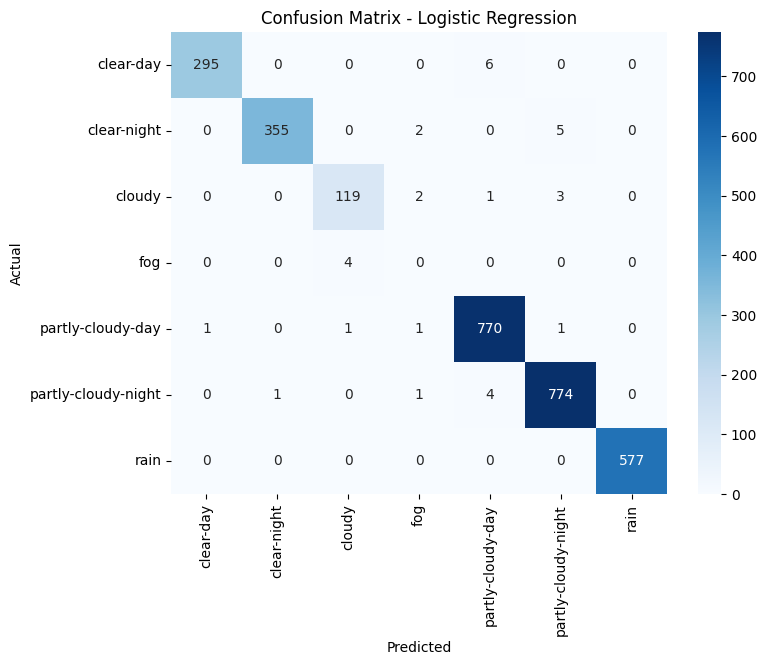

In [72]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [73]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [74]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [75]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 0.9994
cloudy   : 0.9857
fog      : 0.0671
partly-cloudy-day : 0.9997
partly-cloudy-night : 0.9995
rain     : 1.0000
Micro-avg : 0.9976


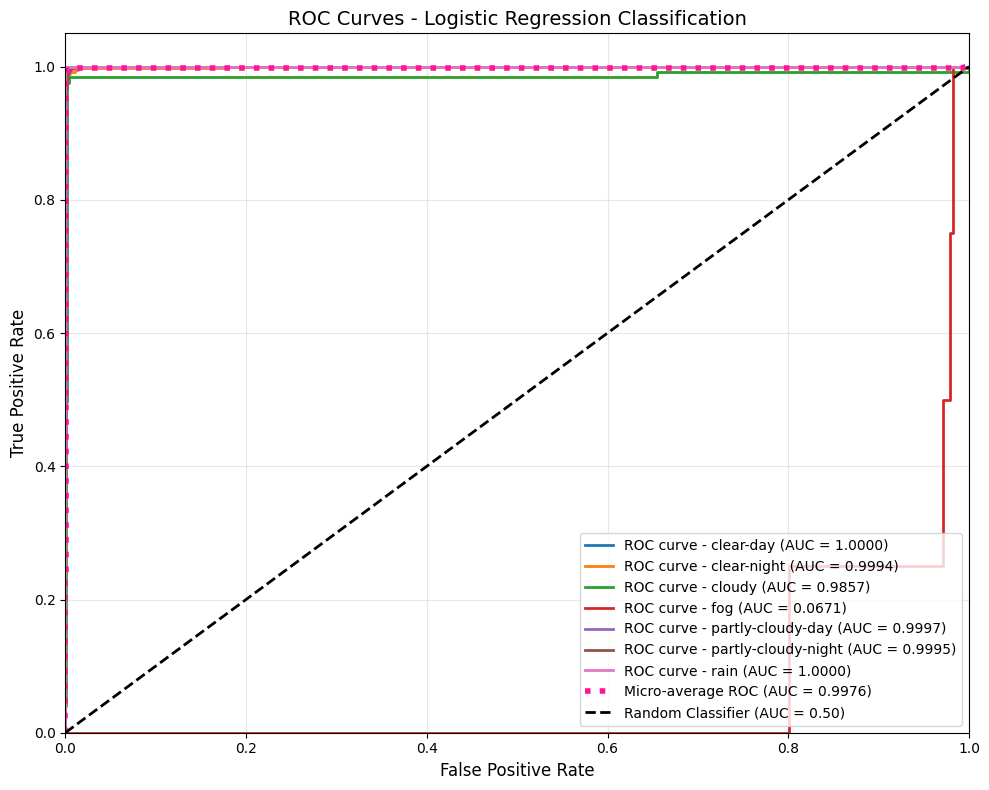

In [76]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [77]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9978
One-vs-One (Weighted)  : 0.9174
Micro-average          : 0.9976


In [78]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.988710, F1: 0.989040, AUC (micro-avg): 0.997600
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [79]:
grid_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass'), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_col_wise=True,
                                            objective='multiclass',
                                            random_state=42, verbose=0),
                   n_iter=350, n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.8, 0.9, 1.0],
                                        'bagging_freq': [0, 1, 5],
                                        'feature_fraction': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [-1, 3, 5, 7, 10],
                                        'min_child_samples': [20, 50, 100, 200],
                                        'min_child_weight': [0.001, 0.01, 0.1],
                                        'min_split_gain': [0.0, 0.1, 0.2],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [31, 50, 100, 150, 200],
                                        'reg_alpha': [0.0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0.0, 0.1, 0.5, 1.0],
                                        'subsample_for_bin': [200000, 300000,
                                                              500000]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [80]:
%%time
print("Starting Grid Search...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    grid_search.fit(X_train, y_train)

Starting Grid Search...
CPU times: total: 13.8 s
Wall time: 19min 55s


In [81]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'subsample_for_bin': 200000, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'num_leaves': 50, 'n_estimators': 200, 'min_split_gain': 0.1, 'min_child_weight': 0.01, 'min_child_samples': 50, 'max_depth': 3, 'learning_rate': 0.1, 'feature_fraction': 0.9, 'bagging_freq': 0, 'bagging_fraction': 0.8}
Best Cross-Validation Score: 0.9915442985707026


In [82]:
y_pred_grid = best_grid_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [83]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [84]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9908
Precision: 0.9901
Recall:    0.9908
F1-Score:  0.9904


In [85]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.98      0.99       301
        clear-night       1.00      0.98      0.99       362
             cloudy       0.96      0.98      0.97       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



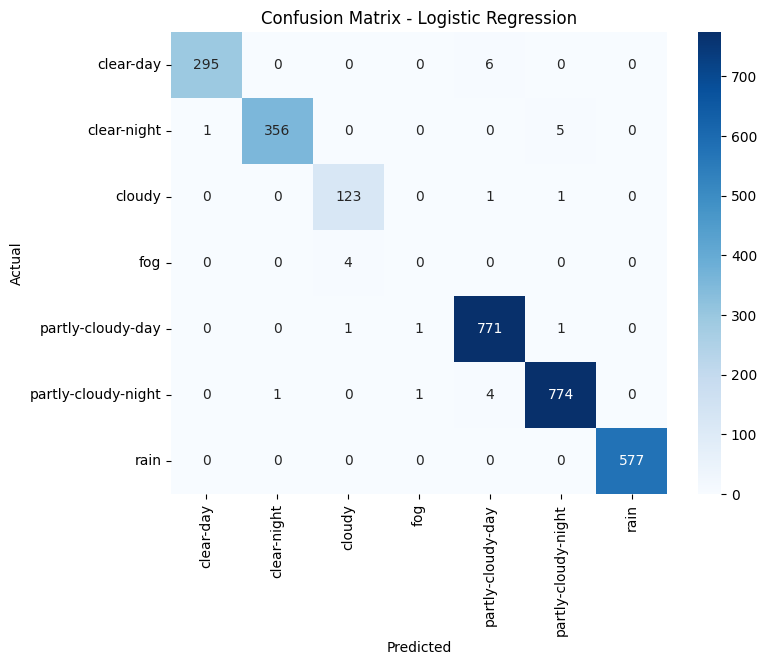

In [86]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [87]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [88]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [89]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 1.0000
cloudy   : 0.9967
fog      : 0.7936
partly-cloudy-day : 0.9997
partly-cloudy-night : 0.9999
rain     : 1.0000
Micro-avg : 0.9994


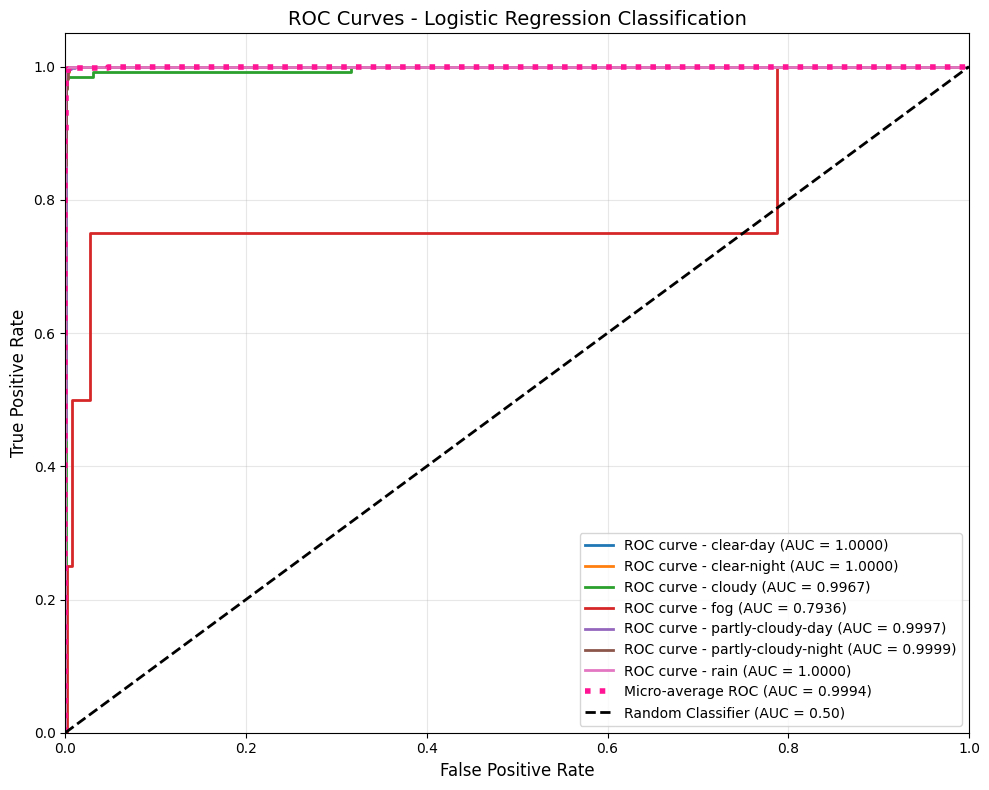

In [90]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [91]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9994
One-vs-One (Weighted)  : 0.9810
Micro-average          : 0.9994


In [92]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.990763, F1: 0.990430, AUC (micro-avg): 0.999406
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [93]:
base_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
base_model

LGBMClassifier(force_col_wise=True, objective='multiclass', random_state=42,
               verbose=0)

In [94]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=LGBMClassifier(force_col_wise=True,
                                           objective='multiclass',
                                           random_state=42, verbose=0),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [95]:
%%time
print("Starting Bagging Ensemble...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    bagging_clf.fit(X_train, y_train)

Starting Bagging Ensemble...
CPU times: total: 6.16 s
Wall time: 1min 21s


In [96]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.9s remaining:    9.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.0s finished


In [97]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [98]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9894
Precision: 0.9881
Recall:    0.9894
F1-Score:  0.9887


In [99]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.98      0.99       301
        clear-night       1.00      0.98      0.99       362
             cloudy       0.96      0.95      0.96       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.84      0.84      2923
       weighted avg       0.99      0.99      0.99      2923



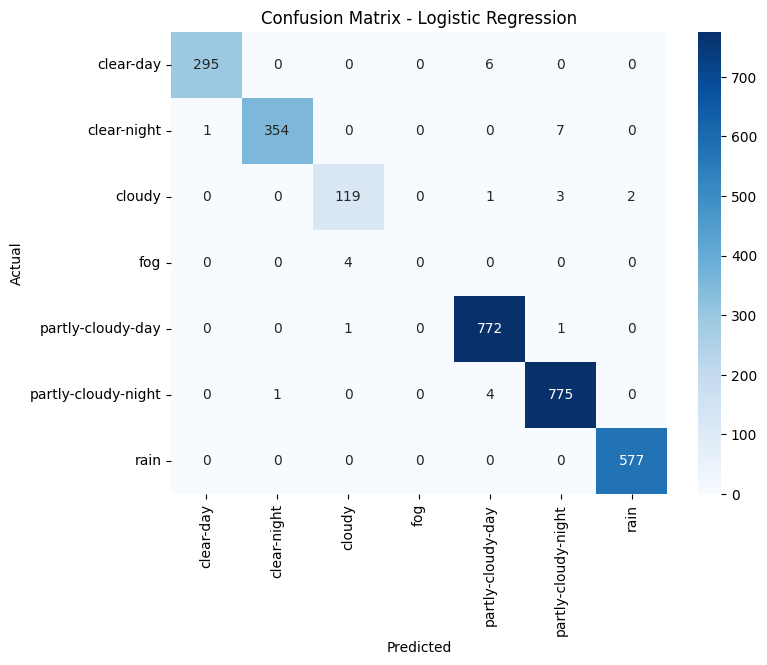

In [100]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [101]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.0s remaining:    9.1s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.3s finished


In [102]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [103]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9997
clear-night : 0.9991
cloudy   : 0.9951
fog      : 0.9299
partly-cloudy-day : 0.9996
partly-cloudy-night : 0.9993
rain     : 1.0000
Micro-avg : 0.9988


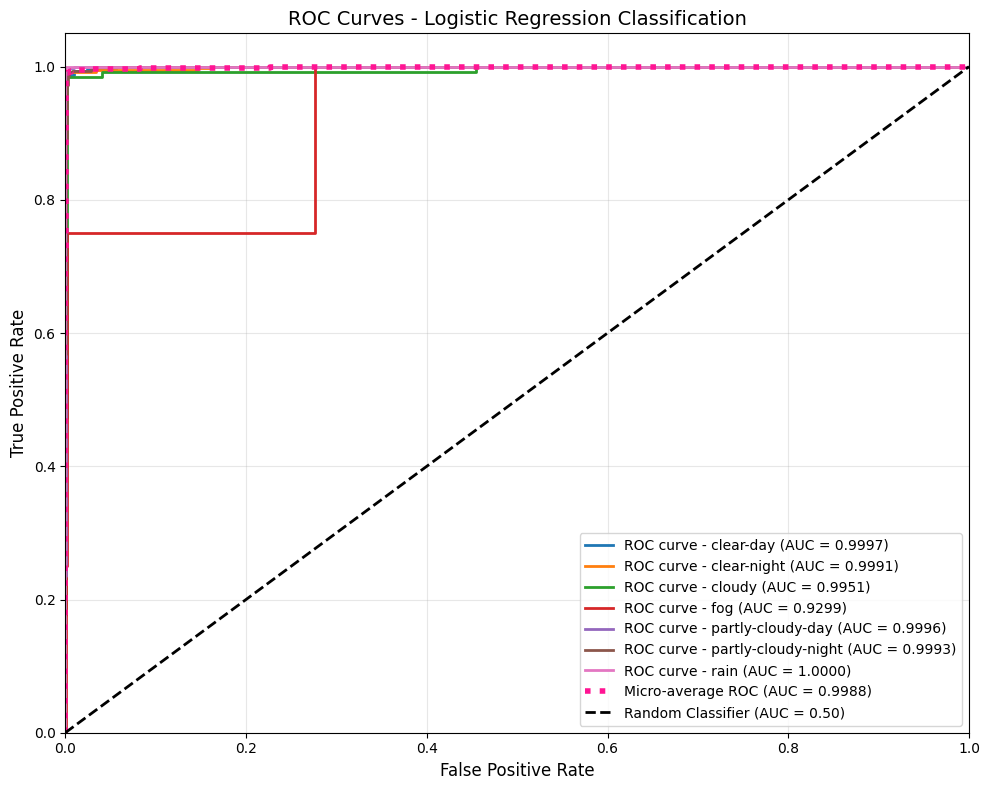

In [104]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [105]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9992
One-vs-One (Weighted)  : 0.9906
Micro-average          : 0.9988


In [106]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.989394, F1: 0.988702, AUC (micro-avg): 0.998765
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Robust Scaler

In [107]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert back to DataFrame to preserve feature names
X_train = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

# Clean column names - replace spaces with underscores
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [108]:
X_train

Month       Day      Hour  DaySegments_Afternoon  \
0        0.0 -0.600000 -0.916667                    0.0   
1        0.0  0.600000  0.583333                    0.0   
2        0.4  0.800000  0.666667                    0.0   
3        0.0  0.600000  0.750000                    0.0   
4        0.0 -0.733333 -1.000000                    0.0   
...      ...       ...       ...                    ...   
11687    0.8  0.800000 -0.083333                    0.0   
11688    0.2  0.866667  0.416667                    1.0   
11689    0.2  0.333333 -0.750000                    0.0   
11690    0.0 -0.333333 -0.083333                    0.0   
11691    0.2 -0.800000 -0.250000                    0.0   

       DaySegments_Early_Morning  DaySegments_Evening  DaySegments_Late_Night  \
0                            0.0                  0.0                     1.0   
1                            0.0                  1.0                     0.0   
2                            0.0                  1.0                     0.0   
3                            0.0                  0.0                     0.0   
4                            0.0                  0.0                     1.0   
...                          ...                  ...                     ...   
11687                        0.0                  0.0                     0.0   
11688                        0.0                  0.0                     0.0   
11689                        0.0                  0.0                     1.0   
11690                        0.0                  0.0                     0.0   
11691                        0.0                  0.0                     0.0   

       DaySegments_Midday  DaySegments_Morning  DaySegments_Night  ...  \
0                     0.0                  0.0                0.0  ...   
1                     0.0                  0.0                0.0  ...   
2                     0.0                  0.0                0.0  ...   
3                     0.0                  0.0                1.0  ...   
4                     0.0                  0.0                0.0  ...   
...                   ...                  ...                ...  ...   
11687                 0.0                  1.0                0.0  ...   
11688                 0.0                  0.0                0.0  ...   
11689                 0.0                  0.0                0.0  ...   
11690                 0.0                  1.0                0.0  ...   
11691                 0.0                  1.0                0.0  ...   

       Humidity  Precip  PrecipProb  Windgust  WindSpeed   WindDir  \
0      0.734301     2.0    1.000000  0.535519   0.002250 -0.404881   
1     -0.354835     0.0    0.000000  1.146131   1.626547 -0.100288   
2      0.748445     1.0    1.500775 -0.149127  -0.249719 -0.128360   
3     -0.235337     0.0    0.000000  1.354839  -0.042745 -0.472179   
4     -0.319229     0.0    0.000000  0.831659  -0.362205 -0.043142   
...         ...     ...         ...       ...        ...       ...   
11687 -0.924034     0.0    0.000000 -0.134320   0.566929 -0.889811   
11688  0.070479     8.0   12.503876  0.752688   1.152981 -0.158876   
11689  0.522619     9.0   13.503876  1.469064   1.005624 -0.218905   
11690 -0.090965     0.0    0.000000  0.217522   0.194601 -0.098283   
11691  0.926960   107.0   15.003101  1.181386   0.186727 -0.027101   

       SeaLevelPressure  CloudCover   UVIndex  SevereRisk  
0             -0.487329   -0.050556  0.000000    9.077106  
1             -0.639376    0.325753  0.000000    0.000000  
2             -0.389864    0.002127  0.000000    1.224199  
3             -0.445419    0.378927  0.000000    0.000000  
4             -0.384990   -0.383181  0.000000   -3.212337  
...                 ...         ...       ...         ...  
11687          0.590643   -0.842277  1.725108    0.000000  
11688         -1.076023    0.594077  0.445887    9.489917  
11689         -0.779727    0.620419  0.000000    0.0000

In [109]:
X_test

Month       Day      Hour  DaySegments_Afternoon  \
0       0.8  1.000000 -0.916667                    0.0   
1      -0.2 -0.333333 -0.750000                    0.0   
2       0.4  0.266667  0.250000                    1.0   
3      -0.6 -0.533333 -0.750000                    0.0   
4       0.4  0.933333  0.083333                    0.0   
...     ...       ...       ...                    ...   
2918    0.8 -0.400000 -0.916667                    0.0   
2919    1.0  0.266667 -0.583333                    0.0   
2920    0.4 -0.733333 -0.750000                    0.0   
2921    1.0 -0.200000  0.166667                    1.0   
2922    0.4 -0.533333 -0.083333                    0.0   

      DaySegments_Early_Morning  DaySegments_Evening  DaySegments_Late_Night  \
0                           0.0                  0.0                     1.0   
1                           0.0                  0.0                     1.0   
2                           0.0                  0.0                     0.0   
3                           0.0                  0.0                     1.0   
4                           0.0                  0.0                     0.0   
...                         ...                  ...                     ...   
2918                        0.0                  0.0                     1.0   
2919                        1.0                  0.0                     0.0   
2920                        0.0                  0.0                     1.0   
2921                        0.0                  0.0                     0.0   
2922                        0.0                  0.0                     0.0   

      DaySegments_Midday  DaySegments_Morning  DaySegments_Night  ...  \
0                    0.0                  0.0                0.0  ...   
1                    0.0                  0.0                0.0  ...   
2                    0.0                  0.0                0.0  ...   
3                    0.0                  0.0                0.0  ...   
4                    1.0                  0.0                0.0  ...   
...                  ...                  ...                ...  ...   
2918                 0.0                  0.0                0.0  ...   
2919                 0.0                  0.0                0.0  ...   
2920                 0.0                  0.0                0.0  ...   
2921                 0.0                  0.0                0.0  ...   
2922                 0.0                  1.0                0.0  ...   

      Humidity  Precip  PrecipProb  Windgust  WindSpeed   WindDir  \
0     0.037313     0.0    0.000000 -0.692755  -0.844769 -1.020835   
1     0.313376    49.0   14.003101 -0.443152  -0.601800 -0.779403   
2    -0.102670   106.0   15.003101  0.193548   0.241845  0.128548   
3    -0.786002     0.0    0.000000 -0.410012  -0.821147  1.141206   
4    -0.971833     0.0    0.000000 -0.636348  -0.411699 -0.906730   
...        ...     ...         ...       ...        ...       ...   
2918  0.190465     0.0    0.000000 -0.247841  -0.858268 -1.003352   
2919  0.373369     0.0    0.000000 -0.606734  -0.831271 -0.962435   
2920  0.523107   127.0   15.003101  0.565838  -0.241845  0.142020   
2921 -1.474698     0.0    0.000000 -0.519302   0.094488 -0.695376   
2922  0.562614    17.0   15.503876  0.743522   1.167604  0.465662   

      SeaLevelPressure  CloudCover   UVIndex  SevereRisk  
0             0.587719   -0.789431  0.000000    0.000000  
1             0.151072   -0.037304  0.000000   -0.427046  
2            -0.539961    0.543030  1.060606    8.265718  
3             0.410331   -0.842277  0.000000    0.000000  
4            -0.432749   -0.032232  1.948052    0.000000  
...                ...         ...       ...         ...  
2918          0.097466   -0.050556  0.000000    7.577699  
2919          0.590643   -0.050556  0.000000    0.000000  
2920         -0.318713    0.090969  0.000000    0.000000  
2921          0.495127   -0.367310  1.515152    0.00

### Default Parameters

In [110]:
training_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
training_model

LGBMClassifier(force_col_wise=True, objective='multiclass', random_state=42,
               verbose=0)

In [111]:
%%time
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    training_model.fit(X_train, y_train)

CPU times: total: 5.67 s
Wall time: 3.04 s


In [112]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'partly-cloudy-day', 'partly-cloudy-day', ...,
       'rain', 'partly-cloudy-day', 'rain'], shape=(2923,), dtype=object)

In [113]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [114]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [115]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.6517
Precision: 0.7770
Recall:    0.6517
F1-Score:  0.6413


In [116]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.78      0.08      0.15       301
        clear-night       0.89      0.85      0.87       362
             cloudy       0.74      0.58      0.65       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.47      0.95      0.63       774
partly-cloudy-night       0.88      0.56      0.69       780
               rain       0.99      0.56      0.71       577

           accuracy                           0.65      2923
          macro avg       0.68      0.51      0.53      2923
       weighted avg       0.78      0.65      0.64      2923



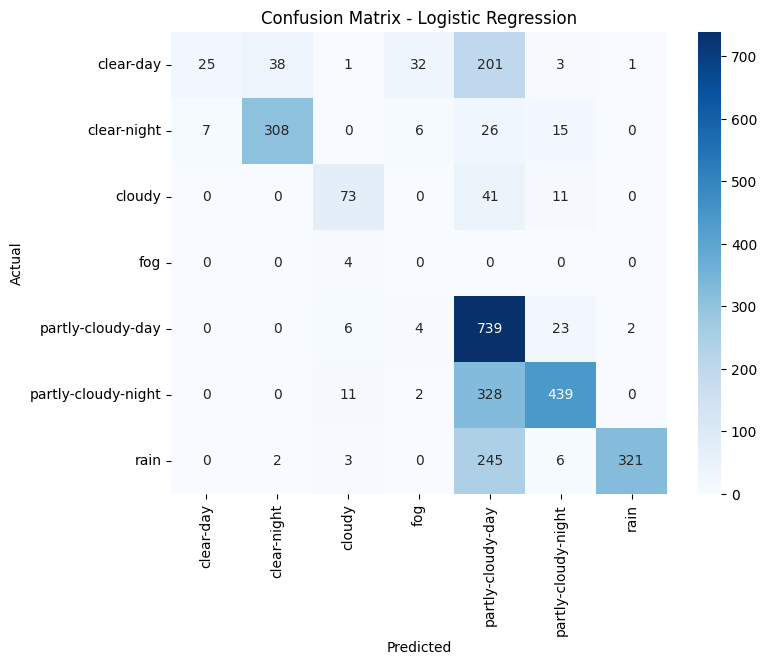

In [117]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [118]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [119]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [120]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.5466
clear-night : 0.9203
cloudy   : 0.8103
fog      : 0.4906
partly-cloudy-day : 0.7821
partly-cloudy-night : 0.7742
rain     : 0.7860
Micro-avg : 0.8018


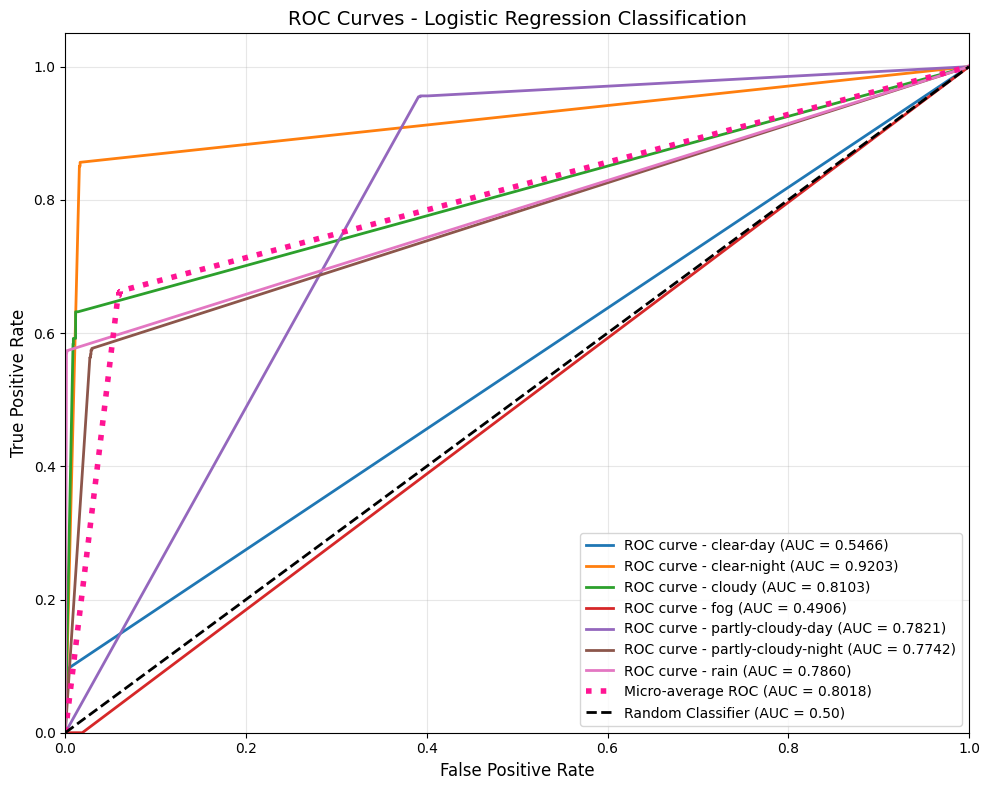

In [121]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [122]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.7744
One-vs-One (Weighted)  : 0.7510
Micro-average          : 0.8018


In [123]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.651728, F1: 0.641294, AUC (micro-avg): 0.801781
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [124]:
grid_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass'), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_col_wise=True,
                                            objective='multiclass',
                                            random_state=42, verbose=0),
                   n_iter=350, n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.8, 0.9, 1.0],
                                        'bagging_freq': [0, 1, 5],
                                        'feature_fraction': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [-1, 3, 5, 7, 10],
                                        'min_child_samples': [20, 50, 100, 200],
                                        'min_child_weight': [0.001, 0.01, 0.1],
                                        'min_split_gain': [0.0, 0.1, 0.2],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [31, 50, 100, 150, 200],
                                        'reg_alpha': [0.0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0.0, 0.1, 0.5, 1.0],
                                        'subsample_for_bin': [200000, 300000,
                                                              500000]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [125]:
%%time
print("Starting Grid Search...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    grid_search.fit(X_train, y_train)

Starting Grid Search...
CPU times: total: 11.9 s
Wall time: 19min 37s


In [126]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'subsample_for_bin': 300000, 'reg_lambda': 1.0, 'reg_alpha': 0.0, 'num_leaves': 100, 'n_estimators': 100, 'min_split_gain': 0.2, 'min_child_weight': 0.001, 'min_child_samples': 100, 'max_depth': 5, 'learning_rate': 0.1, 'feature_fraction': 0.9, 'bagging_freq': 1, 'bagging_fraction': 0.9}
Best Cross-Validation Score: 0.9917583022810377


In [127]:
y_pred_grid = best_grid_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [128]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [129]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9897
Precision: 0.9888
Recall:    0.9897
F1-Score:  0.9892


In [130]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.97      0.99       301
        clear-night       1.00      0.99      0.99       362
             cloudy       0.96      0.97      0.96       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      0.99      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



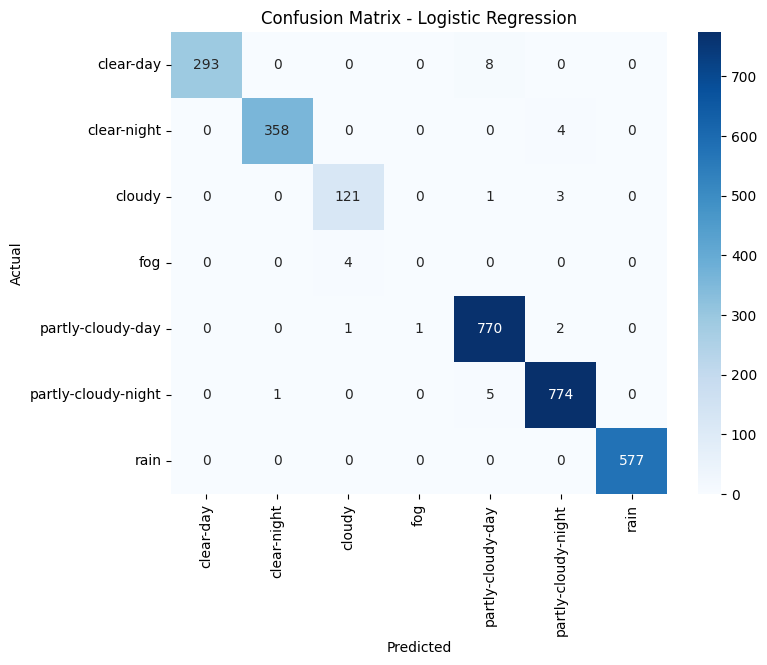

In [131]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [132]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [133]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [134]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 1.0000
cloudy   : 0.9940
fog      : 0.9788
partly-cloudy-day : 0.9997
partly-cloudy-night : 0.9998
rain     : 1.0000
Micro-avg : 0.9995


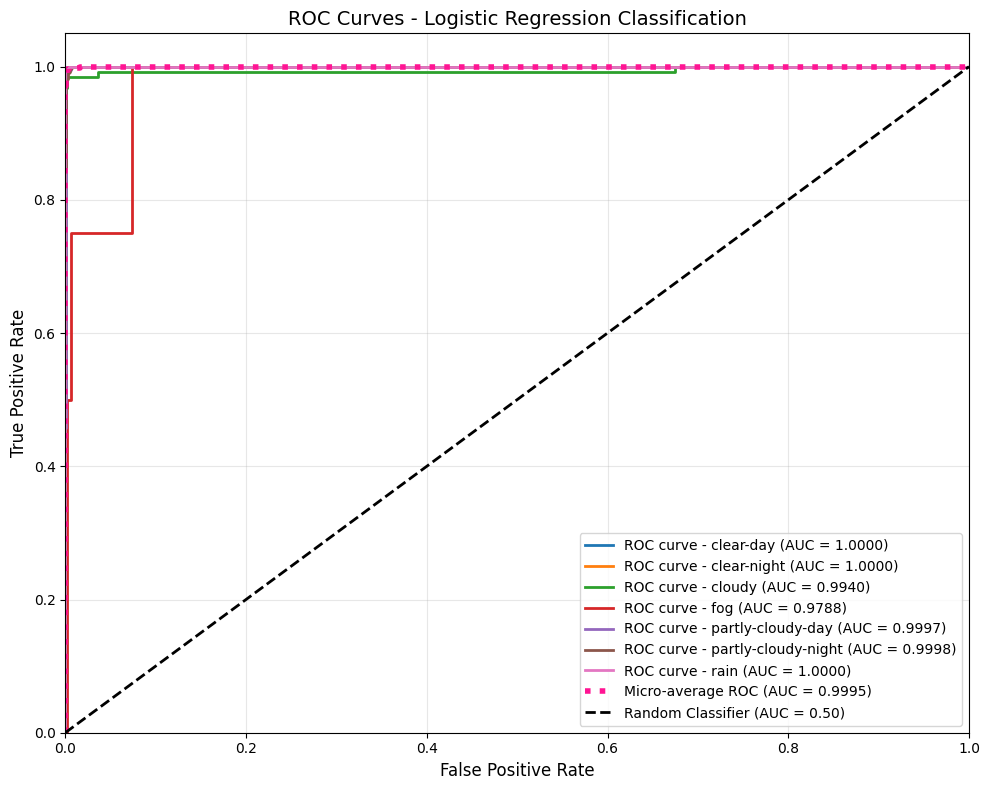

In [135]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [136]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9996
One-vs-One (Weighted)  : 0.9966
Micro-average          : 0.9995


In [137]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.989737, F1: 0.989232, AUC (micro-avg): 0.999514
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [138]:
base_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
base_model

LGBMClassifier(force_col_wise=True, objective='multiclass', random_state=42,
               verbose=0)

In [139]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=LGBMClassifier(force_col_wise=True,
                                           objective='multiclass',
                                           random_state=42, verbose=0),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [140]:
%%time
print("Starting Bagging Ensemble...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    bagging_clf.fit(X_train, y_train)

Starting Bagging Ensemble...
CPU times: total: 6.25 s
Wall time: 1min 18s


In [141]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.2s remaining:    9.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.7s finished


In [142]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [143]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9884
Precision: 0.9871
Recall:    0.9884
F1-Score:  0.9877


In [144]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.97      0.98       301
        clear-night       0.99      0.98      0.99       362
             cloudy       0.97      0.96      0.96       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.84      0.84      2923
       weighted avg       0.99      0.99      0.99      2923



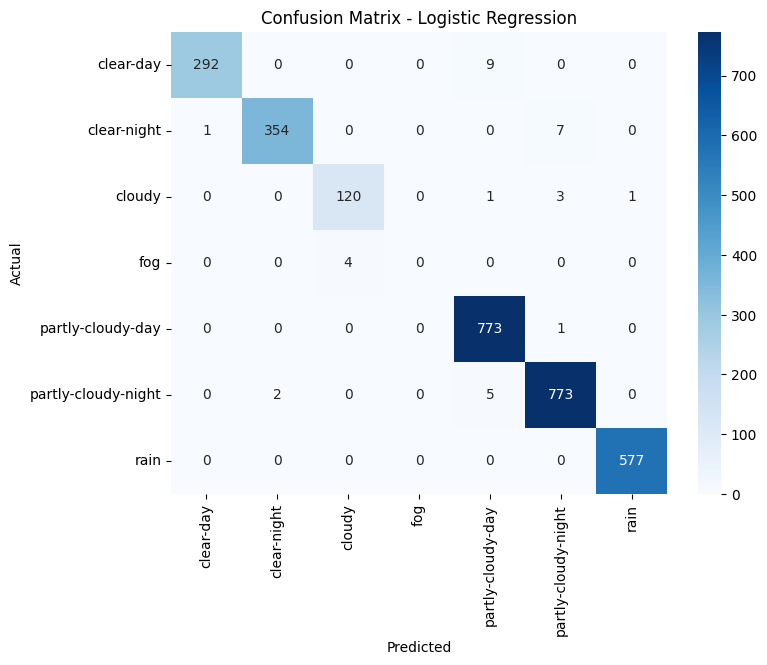

In [145]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [146]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.1s remaining:    9.4s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.2s finished


In [147]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [148]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9994
clear-night : 0.9998
cloudy   : 0.9960
fog      : 0.9731
partly-cloudy-day : 0.9995
partly-cloudy-night : 0.9993
rain     : 1.0000
Micro-avg : 0.9992


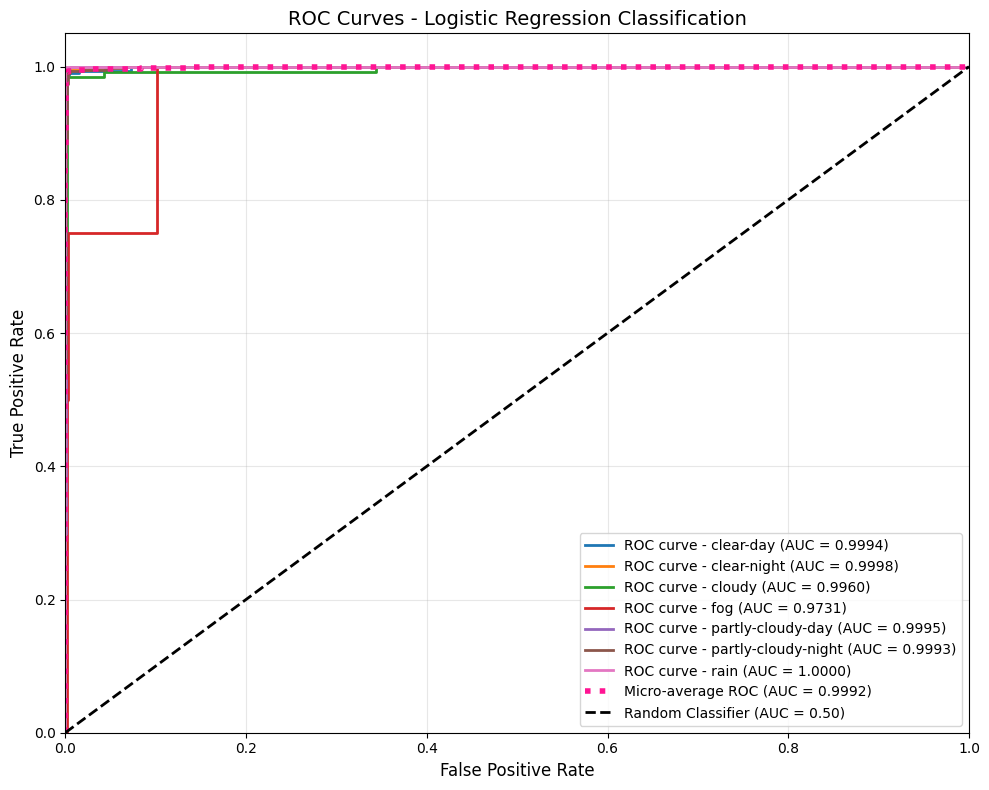

In [149]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [150]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9994
One-vs-One (Weighted)  : 0.9947
Micro-average          : 0.9992


In [151]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.988368, F1: 0.987673, AUC (micro-avg): 0.999155
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


# Selected Features

In [152]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

## Run Again

In [153]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Icon']

In [154]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Icon']

In [155]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [156]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2923
y_test:  2923


### MinMax Scaler

In [157]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert back to DataFrame to preserve feature names
X_train = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

# Clean column names - replace spaces with underscores
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [158]:
X_train

Month      Hour  DaySegments_Afternoon  DaySegments_Early_Morning  \
0      0.454545  0.043478                    0.0                        0.0   
1      0.454545  0.826087                    0.0                        0.0   
2      0.636364  0.869565                    0.0                        0.0   
3      0.454545  0.913043                    0.0                        0.0   
4      0.454545  0.000000                    0.0                        0.0   
...         ...       ...                    ...                        ...   
11687  0.818182  0.478261                    0.0                        0.0   
11688  0.545455  0.739130                    1.0                        0.0   
11689  0.545455  0.130435                    0.0                        0.0   
11690  0.454545  0.478261                    0.0                        0.0   
11691  0.545455  0.391304                    0.0                        0.0   

       DaySegments_Evening  DaySegments_Late_Night  DaySegments_Midday  \
0                      0.0                     1.0                 0.0   
1                      1.0                     0.0                 0.0   
2                      1.0                     0.0                 0.0   
3                      0.0                     0.0                 0.0   
4                      0.0                     1.0                 0.0   
...                    ...                     ...                 ...   
11687                  0.0                     0.0                 0.0   
11688                  0.0                     0.0                 0.0   
11689                  0.0                     1.0                 0.0   
11690                  0.0                     0.0                 0.0   
11691                  0.0                     0.0                 0.0   

       DaySegments_Morning  DaySegments_Night  Season_Autumn  ...      Temp  \
0                      0.0                0.0            0.0  ...  0.613958   
1                      0.0                0.0            0.0  ...  0.668577   
2                      0.0                0.0            0.0  ...  0.581591   
3                      0.0                1.0            0.0  ...  0.634187   
4                      0.0                0.0            0.0  ...  0.674646   
...                    ...                ...            ...  ...       ...   
11687                  1.0                0.0            1.0  ...  0.661160   
11688                  0.0                0.0            0.0  ...  0.684423   
11689                  0.0                0.0            0.0  ...  0.580243   
11690                  1.0                0.0            0.0  ...  0.749494   
11691                  1.0                0.0            0.0  ...  0.593392   

       FeelsLike       Dew  Humidity    Precip  PrecipProb  SeaLevelPressure  \
0       0.640149  0.917554  0.859737  0.000449      0.0645          0.518416   
1       0.608674  0.785404  0.599814  0.000000      0.0000          0.479062   
2       0.560843  0.883235  0.863113  0.000225      0.0968          0.543643   
3       0.568030  0.771598  0.628332  0.000000      0.0000          0.529263   
4       0.633457  0.790927  0.608311  0.000000      0.0000          0.544904   
...          ...       ...       ...       ...         ...               ...   
11687   0.536059  0.652465  0.463974  0.000000      0.0000          0.797427   
11688   0.705328  0.886391  0.701315  0.001798      0.8065          0.366044   
11689   0.543494  0.846548  0.809219  0.002022      0.8710          0.442735   
11690   0.824535  0.929389  0.662787  0.000000      0.0000          0.492180   
11691   0.610409  0.923471  0.905715  0.024045      0.9677          0.543895   

       CloudCover  UVIndex  SevereRisk  
0          0.4839    0.000    0.275807  
1          0.7139    0.000    0.073886  
2          0.5161    0.000    0.101119  
3          0.7464    0.000    0.073886  
4          0.2806    0.000    0.002428  
...           ..

In [159]:
X_test

Month      Hour  DaySegments_Afternoon  DaySegments_Early_Morning  \
0     0.818182  0.043478                    0.0                        0.0   
1     0.363636  0.130435                    0.0                        0.0   
2     0.636364  0.652174                    1.0                        0.0   
3     0.181818  0.130435                    0.0                        0.0   
4     0.636364  0.565217                    0.0                        0.0   
...        ...       ...                    ...                        ...   
2918  0.818182  0.043478                    0.0                        0.0   
2919  0.909091  0.217391                    0.0                        1.0   
2920  0.636364  0.130435                    0.0                        0.0   
2921  0.909091  0.608696                    1.0                        0.0   
2922  0.636364  0.478261                    0.0                        0.0   

      DaySegments_Evening  DaySegments_Late_Night  DaySegments_Midday  \
0                     0.0                     1.0                 0.0   
1                     0.0                     1.0                 0.0   
2                     0.0                     0.0                 0.0   
3                     0.0                     1.0                 0.0   
4                     0.0                     0.0                 1.0   
...                   ...                     ...                 ...   
2918                  0.0                     1.0                 0.0   
2919                  0.0                     0.0                 0.0   
2920                  0.0                     1.0                 0.0   
2921                  0.0                     0.0                 0.0   
2922                  0.0                     0.0                 0.0   

      DaySegments_Morning  DaySegments_Night  Season_Autumn  ...      Temp  \
0                     0.0                0.0            1.0  ...  0.473702   
1                     0.0                0.0            0.0  ...  0.554956   
2                     0.0                0.0            0.0  ...  0.711733   
3                     0.0                0.0            0.0  ...  0.312205   
4                     0.0                0.0            0.0  ...  0.814228   
...                   ...                ...            ...  ...       ...   
2918                  0.0                0.0            1.0  ...  0.608564   
2919                  0.0                0.0            1.0  ...  0.422117   
2920                  0.0                0.0            0.0  ...  0.565745   
2921                  0.0                0.0            1.0  ...  0.711059   
2922                  1.0                0.0            0.0  ...  0.609912   

      FeelsLike       Dew  Humidity    Precip  PrecipProb  SeaLevelPressure  \
0      0.348203  0.643787  0.693400  0.000000      0.0000          0.796670   
1      0.483519  0.781854  0.759283  0.011011      0.9032          0.683653   
2      0.735812  0.884418  0.659993  0.023820      0.9677          0.504793   
3      0.229492  0.302959  0.496915  0.000000      0.0000          0.750757   
4      0.768030  0.805523  0.452567  0.000000      0.0000          0.532543   
...         ...       ...       ...       ...         ...               ...   
2918   0.569269  0.822485  0.729950  0.000000      0.0000          0.669778   
2919   0.310285  0.641420  0.773600  0.000000      0.0000          0.797427   
2920   0.515737  0.829980  0.809335  0.028539      0.9677          0.562059   
2921   0.539529  0.556213  0.332557  0.000000      0.0000          0.772704   
2922   0.606444  0.886785  0.818764  0.003820      1.0000          0.442735   

      CloudCover  UVIndex  SevereRisk  
0         0.0323    0.000    0.073886  
1         0.4920    0.000    0.064387  
2         0.8467    0.490    0.257758  
3         0.0000    0.000    0.073886  
4         0.4951    0.900    0.073886  
...          ...      ...         ...  
2918      0.4839    0.000    

#### Default Parameters

In [160]:
training_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
training_model

LGBMClassifier(force_col_wise=True, objective='multiclass', random_state=42,
               verbose=0)

In [161]:
%%time
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    training_model.fit(X_train, y_train)

CPU times: total: 3.19 s
Wall time: 1.7 s


In [162]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], shape=(2923,), dtype=object)

In [163]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [164]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [165]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9918
Precision: 0.9905
Recall:    0.9918
F1-Score:  0.9911


In [166]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.98      0.99       301
        clear-night       1.00      0.99      0.99       362
             cloudy       0.96      0.98      0.97       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



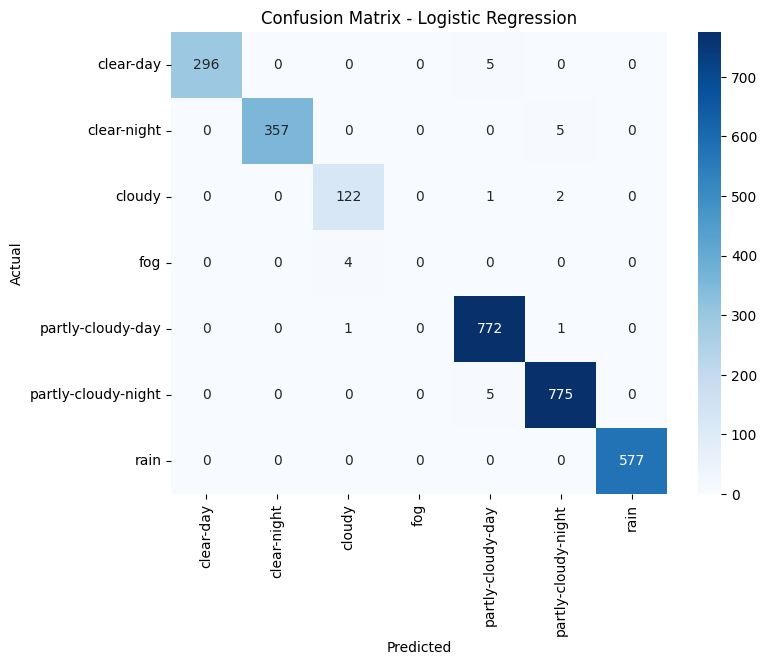

In [167]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [168]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [169]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [170]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 1.0000
cloudy   : 0.9926
fog      : 0.8786
partly-cloudy-day : 0.9996
partly-cloudy-night : 0.9999
rain     : 1.0000
Micro-avg : 0.9992


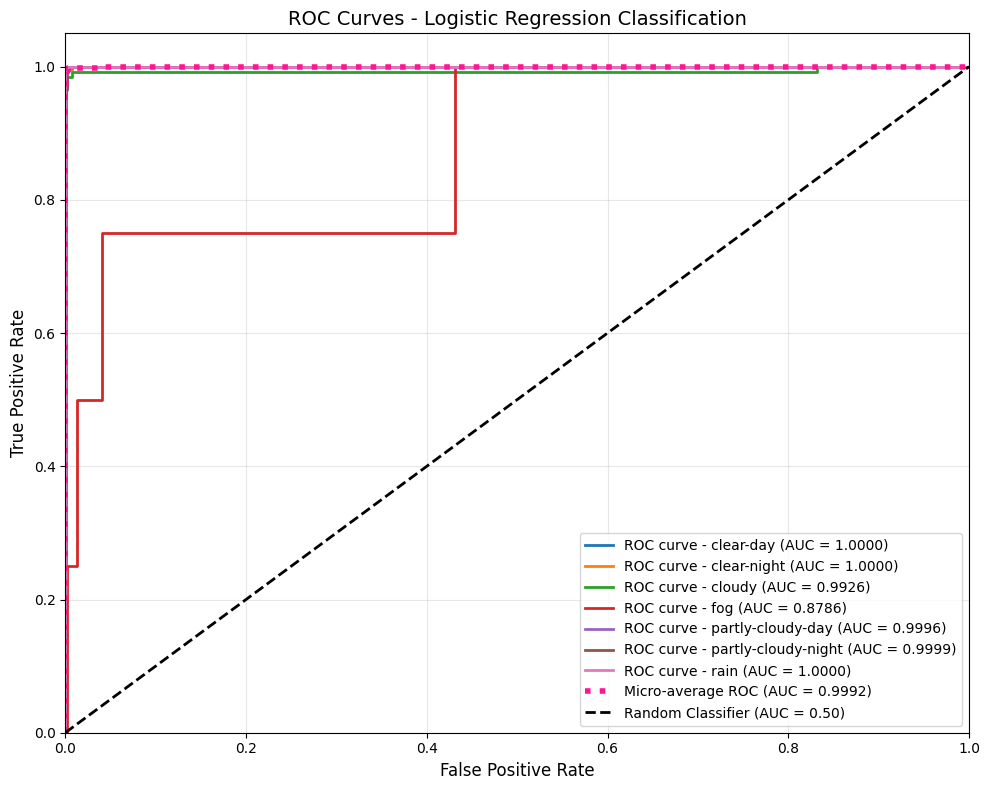

In [171]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [172]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9994
One-vs-One (Weighted)  : 0.9872
Micro-average          : 0.9992


In [173]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.610674 → 0.991789
   F1-Score: 0.564688 → 0.991120
   AUC (micro-avg): 0.775093 → 0.999184
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [174]:
grid_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass'), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_col_wise=True,
                                            objective='multiclass',
                                            random_state=42, verbose=0),
                   n_iter=350, n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.8, 0.9, 1.0],
                                        'bagging_freq': [0, 1, 5],
                                        'feature_fraction': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [-1, 3, 5, 7, 10],
                                        'min_child_samples': [20, 50, 100, 200],
                                        'min_child_weight': [0.001, 0.01, 0.1],
                                        'min_split_gain': [0.0, 0.1, 0.2],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [31, 50, 100, 150, 200],
                                        'reg_alpha': [0.0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0.0, 0.1, 0.5, 1.0],
                                        'subsample_for_bin': [200000, 300000,
                                                              500000]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [175]:
%%time
print("Starting Grid Search...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    grid_search.fit(X_train, y_train)

Starting Grid Search...
CPU times: total: 12.5 s
Wall time: 18min 11s


In [176]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'subsample_for_bin': 200000, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'num_leaves': 200, 'n_estimators': 200, 'min_split_gain': 0.1, 'min_child_weight': 0.01, 'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.05, 'feature_fraction': 1.0, 'bagging_freq': 0, 'bagging_fraction': 1.0}
Best Cross-Validation Score: 0.9915948559474357


In [177]:
y_pred_grid = best_grid_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [178]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [179]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9911
Precision: 0.9898
Recall:    0.9911
F1-Score:  0.9904


In [180]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.98      0.99       301
        clear-night       0.99      0.99      0.99       362
             cloudy       0.96      0.98      0.97       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.98      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



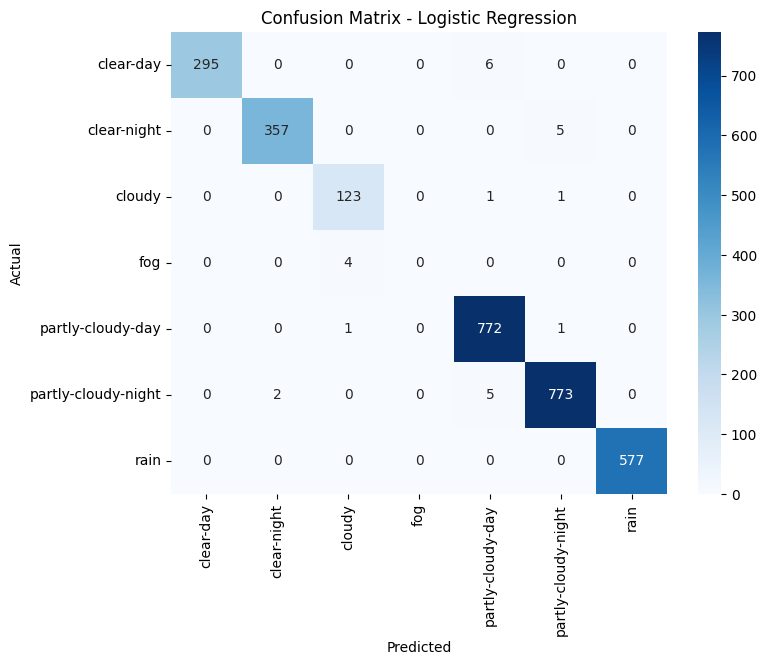

In [181]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [182]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [183]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [184]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 1.0000
cloudy   : 0.9953
fog      : 0.8782
partly-cloudy-day : 0.9997
partly-cloudy-night : 0.9999
rain     : 1.0000
Micro-avg : 0.9993


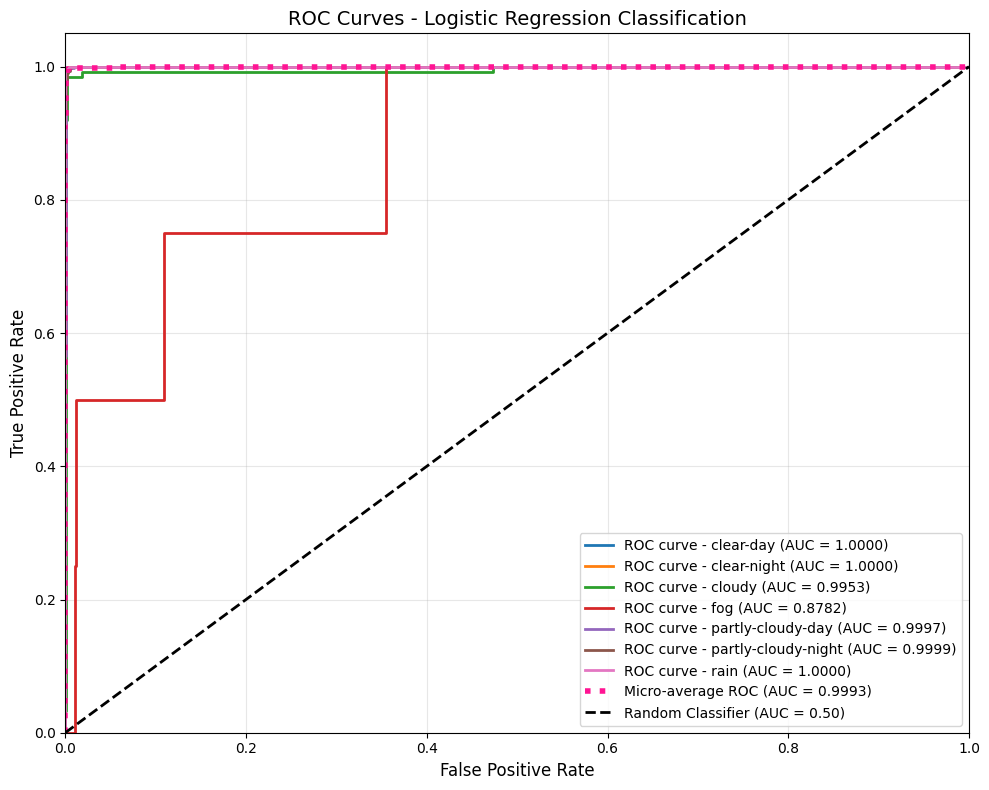

In [185]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [186]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9995
One-vs-One (Weighted)  : 0.9873
Micro-average          : 0.9993


In [187]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.990421 → 0.991105
   F1-Score: 0.989748 → 0.990435
   AUC (micro-avg): 0.999519 → 0.999253
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [188]:
base_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
base_model

LGBMClassifier(force_col_wise=True, objective='multiclass', random_state=42,
               verbose=0)

In [189]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=LGBMClassifier(force_col_wise=True,
                                           objective='multiclass',
                                           random_state=42, verbose=0),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [190]:
%%time
print("Starting Bagging Ensemble...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    bagging_clf.fit(X_train, y_train)

Starting Bagging Ensemble...
CPU times: total: 6.66 s
Wall time: 1min 13s


In [191]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.1s remaining:    9.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.4s finished


In [192]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [193]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9778
Precision: 0.9766
Recall:    0.9778
F1-Score:  0.9766


In [194]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.95      0.97       301
        clear-night       1.00      0.97      0.98       362
             cloudy       0.95      0.78      0.85       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.96      1.00      0.98       774
partly-cloudy-night       0.97      0.99      0.98       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.98      2923
          macro avg       0.84      0.81      0.82      2923
       weighted avg       0.98      0.98      0.98      2923



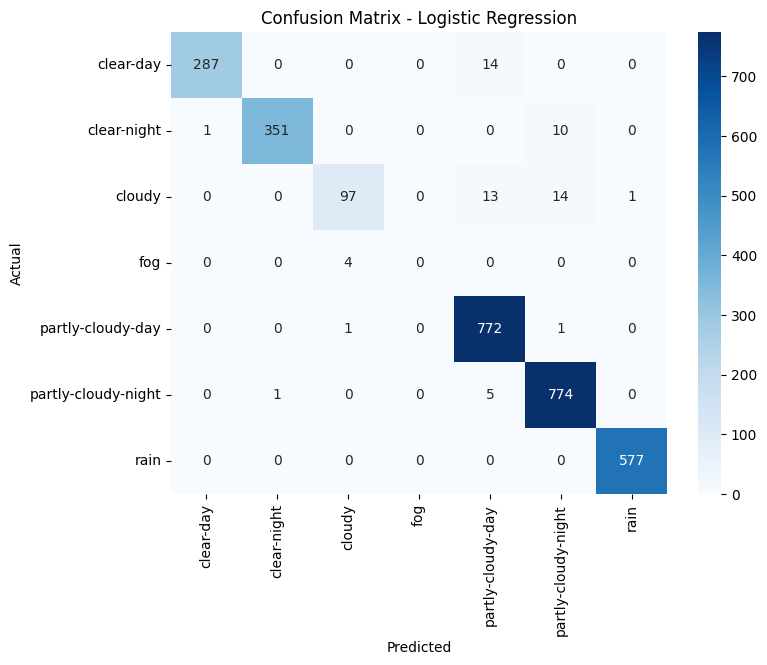

In [195]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [196]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.1s remaining:    9.6s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.3s finished


In [197]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [198]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9988
clear-night : 0.9992
cloudy   : 0.9932
fog      : 0.9921
partly-cloudy-day : 0.9990
partly-cloudy-night : 0.9986
rain     : 1.0000
Micro-avg : 0.9987


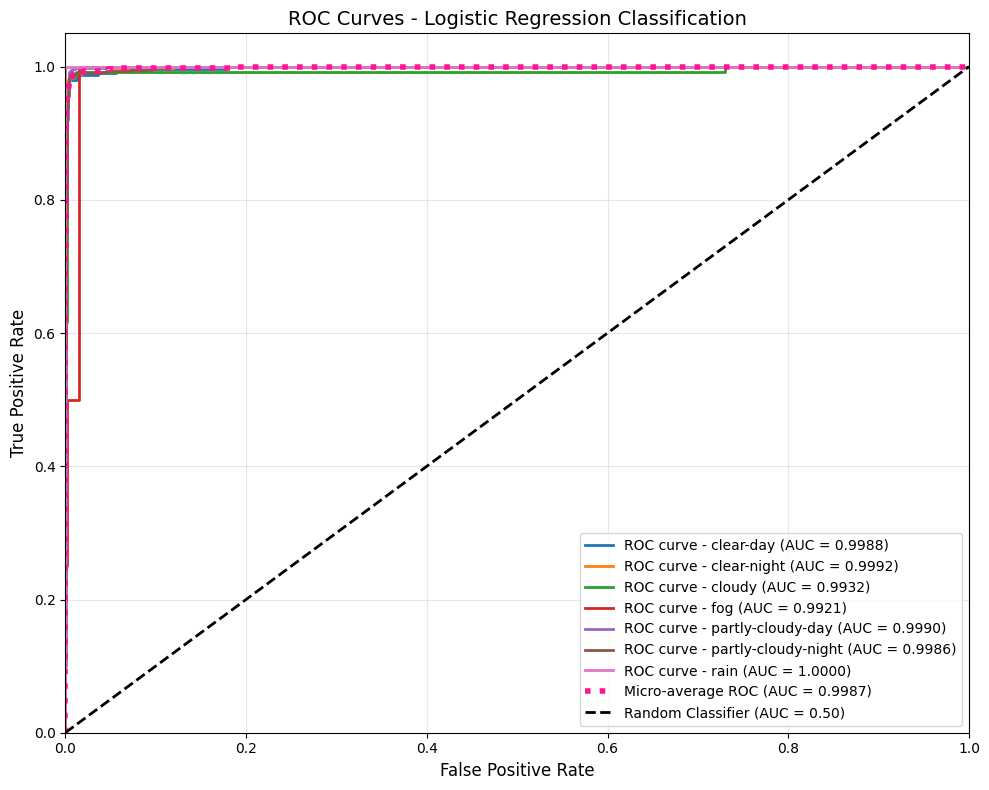

In [199]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [200]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9988
One-vs-One (Weighted)  : 0.9958
Micro-average          : 0.9987


In [201]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.977763, Best Accuracy: 0.989052
   Current F1: 0.976596, Best F1: 0.988371
   Current AUC (micro-avg): 0.998724, Best AUC: 0.999093
   Current Features: 23, Best Features: 27


### Standard Scaler

In [202]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert back to DataFrame to preserve feature names
X_train = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

# Clean column names - replace spaces with underscores
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [203]:
X_train

Month      Hour  DaySegments_Afternoon  DaySegments_Early_Morning  \
0      0.088732 -1.517539              -0.388897                  -0.250817   
1      0.088732  1.075234              -0.388897                  -0.250817   
2      0.713519  1.219277              -0.388897                  -0.250817   
3      0.088732  1.363320              -0.388897                  -0.250817   
4      0.088732 -1.661582              -0.388897                  -0.250817   
...         ...       ...                    ...                        ...   
11687  1.338307 -0.077110              -0.388897                  -0.250817   
11688  0.401126  0.787148               2.571377                  -0.250817   
11689  0.401126 -1.229453              -0.388897                  -0.250817   
11690  0.088732 -0.077110              -0.388897                  -0.250817   
11691  0.401126 -0.365195              -0.388897                  -0.250817   

       DaySegments_Evening  DaySegments_Late_Night  DaySegments_Midday  \
0                -0.334567                1.730866           -0.360086   
1                 2.988935               -0.577745           -0.360086   
2                 2.988935               -0.577745           -0.360086   
3                -0.334567               -0.577745           -0.360086   
4                -0.334567                1.730866           -0.360086   
...                    ...                     ...                 ...   
11687            -0.334567               -0.577745           -0.360086   
11688            -0.334567               -0.577745           -0.360086   
11689            -0.334567                1.730866           -0.360086   
11690            -0.334567               -0.577745           -0.360086   
11691            -0.334567               -0.577745           -0.360086   

       DaySegments_Morning  DaySegments_Night  Season_Autumn  ...      Temp  \
0                -0.559306          -0.343350      -0.417290  ...  0.397449   
1                -0.559306          -0.343350      -0.417290  ...  0.725680   
2                -0.559306          -0.343350      -0.417290  ...  0.202941   
3                -0.559306           2.912484      -0.417290  ...  0.519016   
4                -0.559306          -0.343350      -0.417290  ...  0.762151   
...                    ...                ...            ...  ...       ...   
11687             1.787931          -0.343350       2.396412  ...  0.681106   
11688            -0.559306          -0.343350      -0.417290  ...  0.820908   
11689            -0.559306          -0.343350      -0.417290  ...  0.194836   
11690             1.787931          -0.343350      -0.417290  ...  1.211950   
11691             1.787931          -0.343350      -0.417290  ...  0.273855   

       FeelsLike       Dew  Humidity    Precip  PrecipProb  SeaLevelPressure  \
0       0.870938  1.245354  1.174694 -0.166971   -0.348147         -0.879673   
1       0.700881  0.553181 -0.335607 -0.189481   -0.520404         -1.138399   
2       0.442447  1.065596  1.194308 -0.178226   -0.261884         -0.713822   
3       0.481279  0.480865 -0.169900 -0.189481   -0.520404         -0.808357   
4       0.834784  0.582108 -0.286233 -0.189481   -0.520404         -0.705530   
...          ...       ...       ...       ...         ...               ...   
11687   0.308543 -0.143123 -1.124914 -0.189481   -0.520404          0.954634   
11688   1.223104  1.082125  0.254175 -0.099439    1.633484         -1.881409   
11689   0.348714  0.873440  0.881156 -0.088184    1.805741         -1.377224   
11690   1.867180  1.307340  0.030301 -0.189481   -0.520404         -1.052157   
11691   0.710254  1.276347  1.441854  1.014831    2.063994         -0.712164   

       CloudCover   UVIndex  SevereRisk  
0       -0.144895 -0.730586    0.852923  
1        0.509077 -0.730586   -0.429922  
2       -0.053339 -0.730586   -0.256909  
3        0.601486 -0.730586   -0.429922  
4       -0.722950 -0.730586   -0.883914  
...       

In [204]:
X_test

Month      Hour  DaySegments_Afternoon  DaySegments_Early_Morning  \
0     1.338307 -1.517539              -0.388897                  -0.250817   
1    -0.223661 -1.229453              -0.388897                  -0.250817   
2     0.713519  0.499062               2.571377                  -0.250817   
3    -0.848448 -1.229453              -0.388897                  -0.250817   
4     0.713519  0.210976              -0.388897                  -0.250817   
...        ...       ...                    ...                        ...   
2918  1.338307 -1.517539              -0.388897                  -0.250817   
2919  1.650700 -0.941367              -0.388897                   3.986973   
2920  0.713519 -1.229453              -0.388897                  -0.250817   
2921  1.650700  0.355019               2.571377                  -0.250817   
2922  0.713519 -0.077110              -0.388897                  -0.250817   

      DaySegments_Evening  DaySegments_Late_Night  DaySegments_Midday  \
0               -0.334567                1.730866           -0.360086   
1               -0.334567                1.730866           -0.360086   
2               -0.334567               -0.577745           -0.360086   
3               -0.334567                1.730866           -0.360086   
4               -0.334567               -0.577745            2.777115   
...                   ...                     ...                 ...   
2918            -0.334567                1.730866           -0.360086   
2919            -0.334567               -0.577745           -0.360086   
2920            -0.334567                1.730866           -0.360086   
2921            -0.334567               -0.577745           -0.360086   
2922            -0.334567               -0.577745           -0.360086   

      DaySegments_Morning  DaySegments_Night  Season_Autumn  ...      Temp  \
0               -0.559306           -0.34335       2.396412  ... -0.445418   
1               -0.559306           -0.34335      -0.417290  ...  0.042877   
2               -0.559306           -0.34335      -0.417290  ...  0.985024   
3               -0.559306           -0.34335      -0.417290  ... -1.415931   
4               -0.559306           -0.34335      -0.417290  ...  1.600965   
...                   ...                ...            ...  ...       ...   
2918            -0.559306           -0.34335       2.396412  ...  0.365031   
2919            -0.559306           -0.34335       2.396412  ... -0.755415   
2920            -0.559306           -0.34335      -0.417290  ...  0.107713   
2921            -0.559306           -0.34335       2.396412  ...  0.980972   
2922             1.787931           -0.34335      -0.417290  ...  0.373135   

      FeelsLike       Dew  Humidity    Precip  PrecipProb  SeaLevelPressure  \
0     -0.706445 -0.188579  0.208182 -0.189481   -0.520404          0.949658   
1      0.024668  0.534586  0.590999  0.362026    1.891737          0.206648   
2      1.387806  1.071794  0.014068  1.003575    2.063994         -0.969232   
3     -1.347843 -1.973765 -0.933505 -0.189481   -0.520404          0.647810   
4      1.561880  0.658557 -1.191197 -0.189481   -0.520404         -0.786796   
...         ...       ...       ...       ...         ...               ...   
2918   0.487974  0.747403  0.420558 -0.189481   -0.520404          0.115430   
2919  -0.911318 -0.200977  0.674191 -0.189481   -0.520404          0.954634   
2920   0.198742  0.786661  0.881832  1.239936    2.063994         -0.592751   
2921   0.327290 -0.647273 -1.888519 -0.189481   -0.520404          0.792100   
2922   0.688829  1.084191  0.936617  0.001858    2.150257         -1.377224   

      CloudCover   UVIndex  SevereRisk  
0      -1.428956 -0.730586   -0.429922  
1      -0.121864 -0.730586   -0.490276  
2       0.886675  0.864314    0.738252  
3      -1.520796 -0.730586   -0.429922  
4      -0.113050  2.198822   -0.429922  
...          ...       ...         ...  
2918   -0.144895 -0.73

#### Default Parameters

In [205]:
training_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
training_model

LGBMClassifier(force_col_wise=True, objective='multiclass', random_state=42,
               verbose=0)

In [206]:
%%time
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    training_model.fit(X_train, y_train)

CPU times: total: 4.03 s
Wall time: 2.11 s


In [207]:
y_pred = training_model.predict(X_test)
y_pred

array(['partly-cloudy-day', 'rain', 'rain', ..., 'rain',
       'partly-cloudy-day', 'rain'], shape=(2923,), dtype=object)

In [208]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [209]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [210]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.4824
Precision: 0.4889
Recall:    0.4824
F1-Score:  0.4483


In [211]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       0.51      0.11      0.18       301
        clear-night       0.00      0.00      0.00       362
             cloudy       0.67      0.50      0.58       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.36      0.73      0.49       774
partly-cloudy-night       0.51      0.55      0.53       780
               rain       0.88      0.55      0.68       577

           accuracy                           0.48      2923
          macro avg       0.42      0.35      0.35      2923
       weighted avg       0.49      0.48      0.45      2923



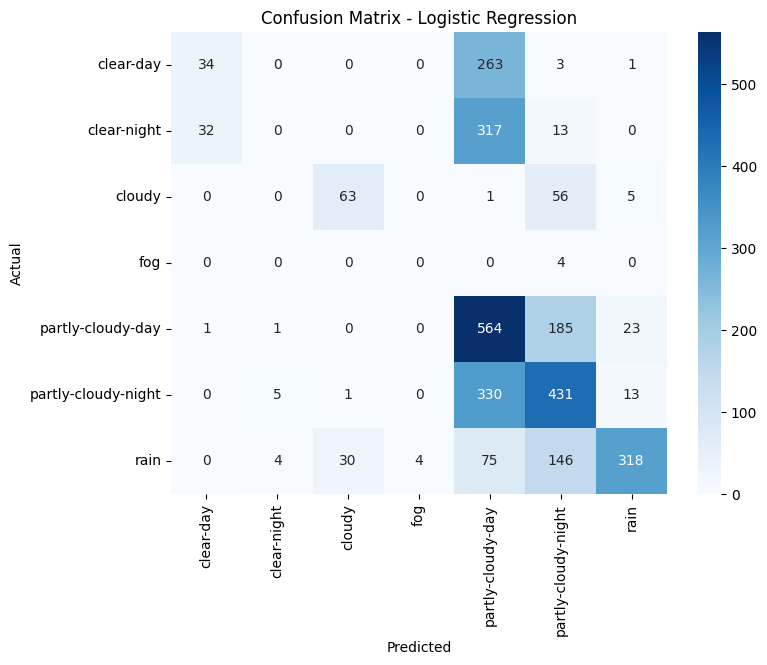

In [212]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [213]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [214]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [215]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.5515
clear-night : 0.4945
cloudy   : 0.7495
fog      : 0.4978
partly-cloudy-day : 0.6381
partly-cloudy-night : 0.6817
rain     : 0.7783
Micro-avg : 0.7021


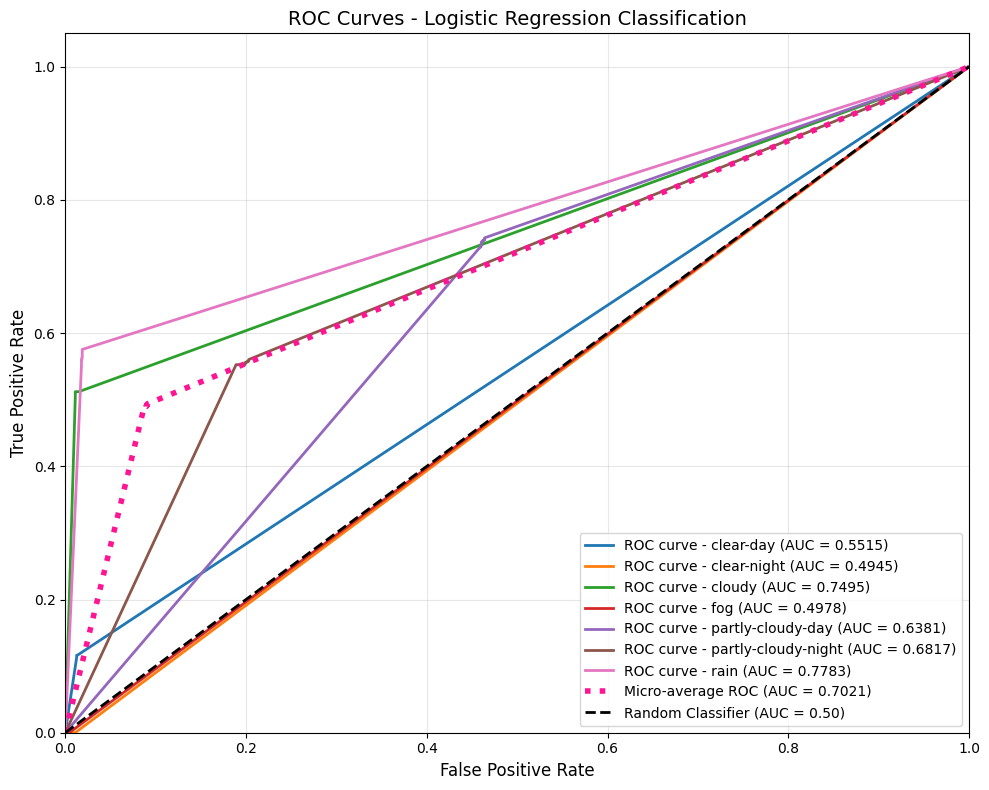

In [216]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [217]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.6553
One-vs-One (Weighted)  : 0.6349
Micro-average          : 0.7021


In [218]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.482381, Best Accuracy: 0.988710
   Current F1: 0.448310, Best F1: 0.989040
   Current AUC (micro-avg): 0.702074, Best AUC: 0.997600
   Current Features: 23, Best Features: 27


#### Tuning with Grid Search

In [219]:
grid_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass'), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_col_wise=True,
                                            objective='multiclass',
                                            random_state=42, verbose=0),
                   n_iter=350, n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.8, 0.9, 1.0],
                                        'bagging_freq': [0, 1, 5],
                                        'feature_fraction': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [-1, 3, 5, 7, 10],
                                        'min_child_samples': [20, 50, 100, 200],
                                        'min_child_weight': [0.001, 0.01, 0.1],
                                        'min_split_gain': [0.0, 0.1, 0.2],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [31, 50, 100, 150, 200],
                                        'reg_alpha': [0.0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0.0, 0.1, 0.5, 1.0],
                                        'subsample_for_bin': [200000, 300000,
                                                              500000]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [220]:
%%time
print("Starting Grid Search...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    grid_search.fit(X_train, y_train)

Starting Grid Search...
CPU times: total: 13.1 s
Wall time: 18min 37s


In [221]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'subsample_for_bin': 500000, 'reg_lambda': 0.1, 'reg_alpha': 1.0, 'num_leaves': 50, 'n_estimators': 300, 'min_split_gain': 0.0, 'min_child_weight': 0.01, 'min_child_samples': 200, 'max_depth': 5, 'learning_rate': 0.1, 'feature_fraction': 0.9, 'bagging_freq': 0, 'bagging_fraction': 0.9}
Best Cross-Validation Score: 0.9921350048789858


In [222]:
y_pred_grid = best_grid_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [223]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [224]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9932
Precision: 0.9918
Recall:    0.9932
F1-Score:  0.9925


In [225]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.99      1.00       301
        clear-night       1.00      0.99      0.99       362
             cloudy       0.96      0.98      0.97       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



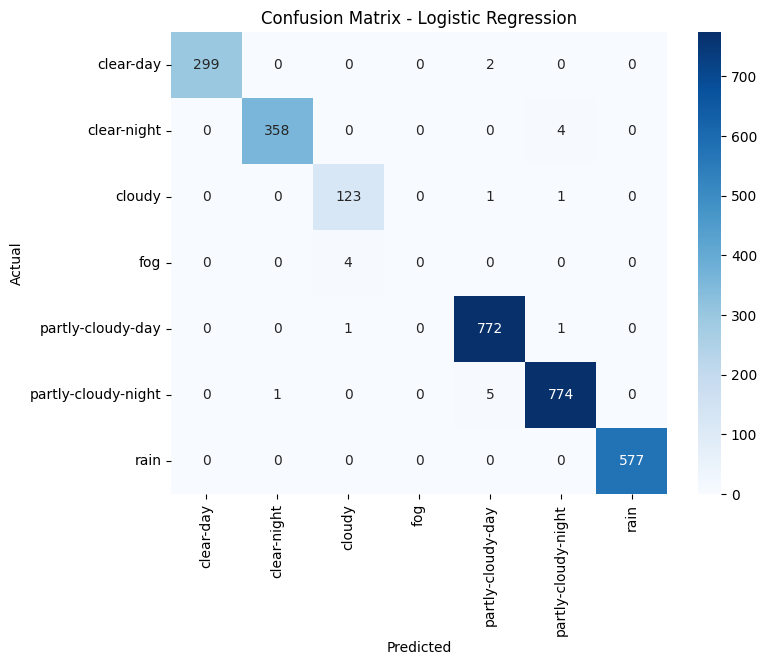

In [226]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [227]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [228]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [229]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 1.0000
cloudy   : 0.9946
fog      : 0.9768
partly-cloudy-day : 0.9997
partly-cloudy-night : 0.9999
rain     : 1.0000
Micro-avg : 0.9996


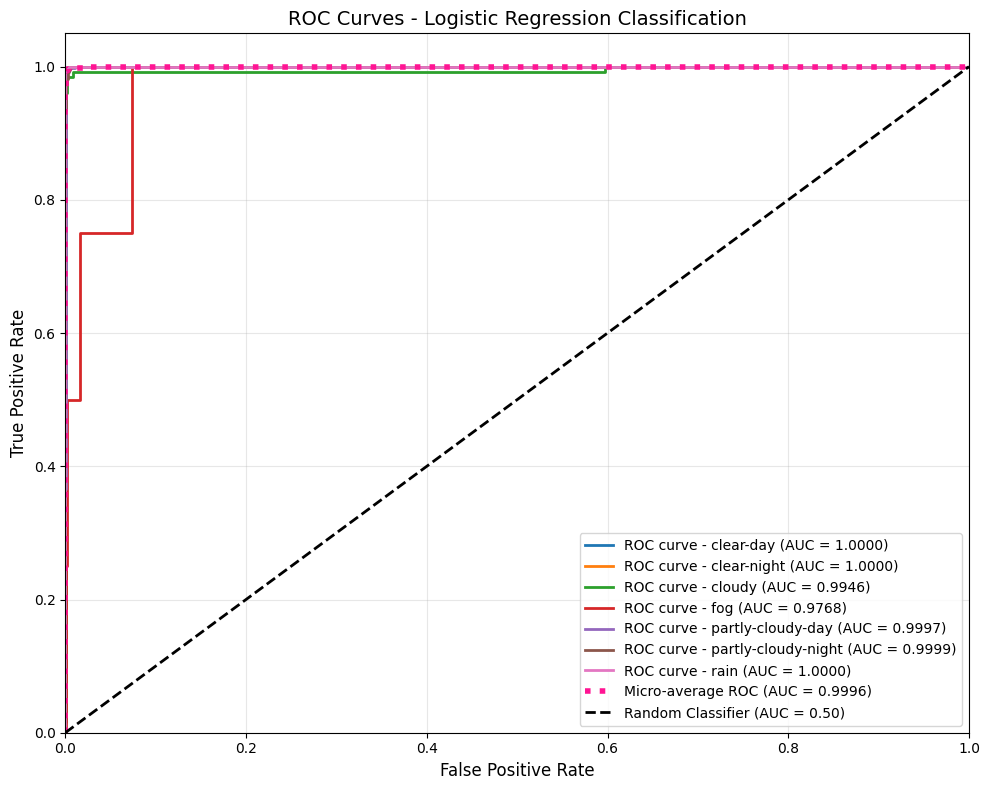

In [230]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [231]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9996
One-vs-One (Weighted)  : 0.9961
Micro-average          : 0.9996


In [232]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.990763 → 0.993158
   F1-Score: 0.990430 → 0.992490
   AUC (micro-avg): 0.999406 → 0.999561
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [233]:
base_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
base_model

LGBMClassifier(force_col_wise=True, objective='multiclass', random_state=42,
               verbose=0)

In [234]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=LGBMClassifier(force_col_wise=True,
                                           objective='multiclass',
                                           random_state=42, verbose=0),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [235]:
%%time
print("Starting Bagging Ensemble...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    bagging_clf.fit(X_train, y_train)

Starting Bagging Ensemble...
CPU times: total: 6.38 s
Wall time: 1min 15s


In [236]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.0s remaining:    9.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.3s finished


In [237]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [238]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9826
Precision: 0.9813
Recall:    0.9826
F1-Score:  0.9816


In [239]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.97      0.98       301
        clear-night       1.00      0.97      0.98       362
             cloudy       0.95      0.84      0.89       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.97      1.00      0.99       774
partly-cloudy-night       0.97      0.99      0.98       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.98      2923
          macro avg       0.84      0.82      0.83      2923
       weighted avg       0.98      0.98      0.98      2923



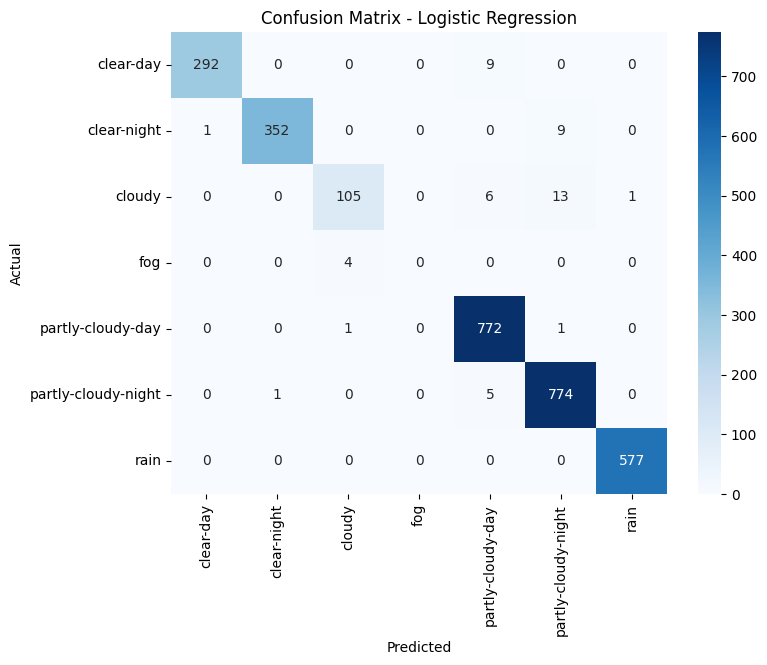

In [240]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [241]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.0s remaining:    9.3s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.8s finished


In [242]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [243]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9991
clear-night : 0.9989
cloudy   : 0.9937
fog      : 0.9908
partly-cloudy-day : 0.9991
partly-cloudy-night : 0.9986
rain     : 1.0000
Micro-avg : 0.9988


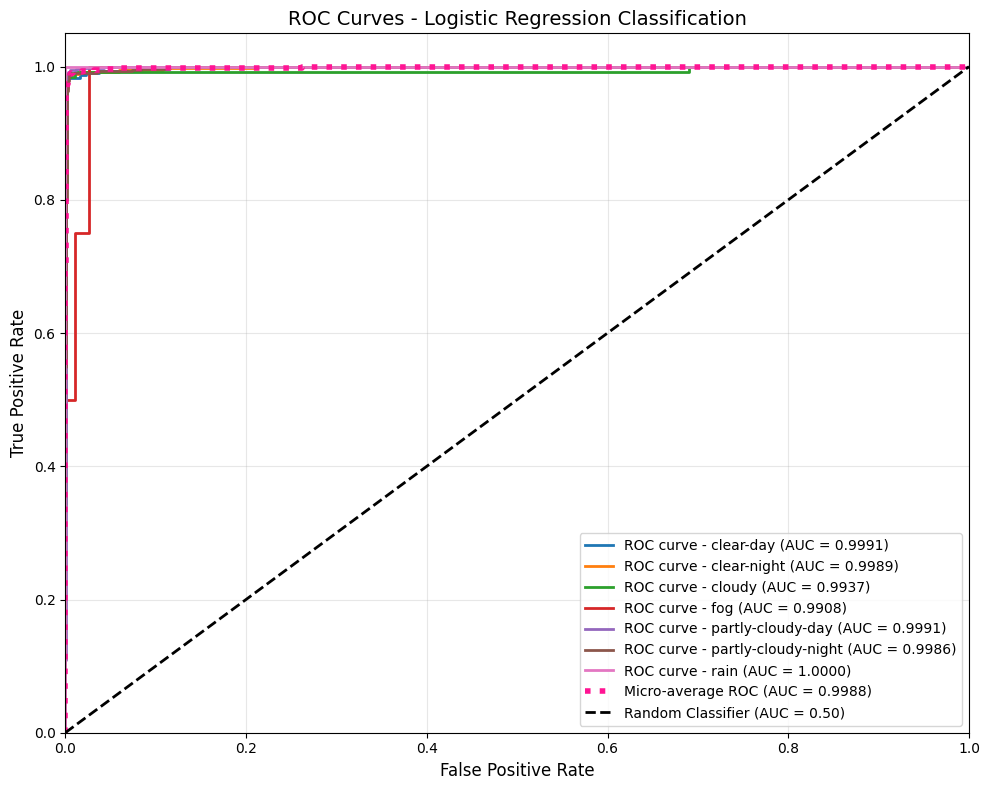

In [244]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [245]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9989
One-vs-One (Weighted)  : 0.9960
Micro-average          : 0.9988


In [246]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.989394 ≈ 0.982552 (similar)
   F1-Score: 0.988702 ≈ 0.981645 (similar)
   AUC (micro-avg): 0.998765 ≈ 0.998809
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


### Robust Scaler

In [247]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert back to DataFrame to preserve feature names
X_train = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

# Clean column names - replace spaces with underscores
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [248]:
X_train

Month      Hour  DaySegments_Afternoon  DaySegments_Early_Morning  \
0        0.0 -0.916667                    0.0                        0.0   
1        0.0  0.583333                    0.0                        0.0   
2        0.4  0.666667                    0.0                        0.0   
3        0.0  0.750000                    0.0                        0.0   
4        0.0 -1.000000                    0.0                        0.0   
...      ...       ...                    ...                        ...   
11687    0.8 -0.083333                    0.0                        0.0   
11688    0.2  0.416667                    1.0                        0.0   
11689    0.2 -0.750000                    0.0                        0.0   
11690    0.0 -0.083333                    0.0                        0.0   
11691    0.2 -0.250000                    0.0                        0.0   

       DaySegments_Evening  DaySegments_Late_Night  DaySegments_Midday  \
0                      0.0                     1.0                 0.0   
1                      1.0                     0.0                 0.0   
2                      1.0                     0.0                 0.0   
3                      0.0                     0.0                 0.0   
4                      0.0                     1.0                 0.0   
...                    ...                     ...                 ...   
11687                  0.0                     0.0                 0.0   
11688                  0.0                     0.0                 0.0   
11689                  0.0                     1.0                 0.0   
11690                  0.0                     0.0                 0.0   
11691                  0.0                     0.0                 0.0   

       DaySegments_Morning  DaySegments_Night  Season_Autumn  ...      Temp  \
0                      0.0                0.0            0.0  ...  0.187744   
1                      0.0                0.0            0.0  ...  0.469361   
2                      0.0                0.0            0.0  ...  0.020860   
3                      0.0                1.0            0.0  ...  0.292047   
4                      0.0                0.0            0.0  ...  0.500652   
...                    ...                ...            ...  ...       ...   
11687                  1.0                0.0            1.0  ...  0.431117   
11688                  0.0                0.0            0.0  ...  0.551065   
11689                  0.0                0.0            0.0  ...  0.013907   
11690                  1.0                0.0            0.0  ...  0.886571   
11691                  1.0                0.0            0.0  ...  0.081704   

       FeelsLike       Dew  Humidity  Precip  PrecipProb  SeaLevelPressure  \
0       0.485304  0.621359  0.734301     2.0    1.000000         -0.487329   
1       0.373039  0.201691 -0.354835     0.0    0.000000         -0.639376   
2       0.202431  0.512371  0.748445     1.0    1.500775         -0.389864   
3       0.228066  0.157845 -0.235337     0.0    0.000000         -0.445419   
4       0.461436  0.219230 -0.319229     0.0    0.000000         -0.384990   
...          ...       ...       ...     ...         ...               ...   
11687   0.114033 -0.220482 -0.924034     0.0    0.000000          0.590643   
11688   0.717790  0.522393  0.070479     8.0   12.503876         -1.076023   
11689   0.140552  0.395866  0.522619     9.0   13.503876         -0.779727   
11690   1.142983  0.658941 -0.090965     0.0    0.000000         -0.588694   
11691   0.379227  0.640150  0.926960   107.0   15.003101         -0.388889   

       CloudCover   UVIndex  SevereRisk  
0       -0.050556  0.000000    9.077106  
1        0.325753  0.000000    0.000000  
2        0.002127  0.000000    1.224199  
3        0.378927  0.000000    0.000000  
4       -0.383181  0.000000   -3.212337  
...           ...       ...         ...  
11687   -0.842277  1.7251

In [249]:
X_test

Month      Hour  DaySegments_Afternoon  DaySegments_Early_Morning  \
0       0.8 -0.916667                    0.0                        0.0   
1      -0.2 -0.750000                    0.0                        0.0   
2       0.4  0.250000                    1.0                        0.0   
3      -0.6 -0.750000                    0.0                        0.0   
4       0.4  0.083333                    0.0                        0.0   
...     ...       ...                    ...                        ...   
2918    0.8 -0.916667                    0.0                        0.0   
2919    1.0 -0.583333                    0.0                        1.0   
2920    0.4 -0.750000                    0.0                        0.0   
2921    1.0  0.166667                    1.0                        0.0   
2922    0.4 -0.083333                    0.0                        0.0   

      DaySegments_Evening  DaySegments_Late_Night  DaySegments_Midday  \
0                     0.0                     1.0                 0.0   
1                     0.0                     1.0                 0.0   
2                     0.0                     0.0                 0.0   
3                     0.0                     1.0                 0.0   
4                     0.0                     0.0                 1.0   
...                   ...                     ...                 ...   
2918                  0.0                     1.0                 0.0   
2919                  0.0                     0.0                 0.0   
2920                  0.0                     1.0                 0.0   
2921                  0.0                     0.0                 0.0   
2922                  0.0                     0.0                 0.0   

      DaySegments_Morning  DaySegments_Night  Season_Autumn  ...      Temp  \
0                     0.0                0.0            1.0  ... -0.535419   
1                     0.0                0.0            0.0  ... -0.116471   
2                     0.0                0.0            0.0  ...  0.691873   
3                     0.0                0.0            0.0  ... -1.368101   
4                     0.0                0.0            0.0  ...  1.220339   
...                   ...                ...            ...  ...       ...   
2918                  0.0                0.0            1.0  ...  0.159930   
2919                  0.0                0.0            1.0  ... -0.801391   
2920                  0.0                0.0            0.0  ... -0.060843   
2921                  0.0                0.0            1.0  ...  0.688396   
2922                  1.0                0.0            0.0  ...  0.166884   

      FeelsLike       Dew  Humidity  Precip  PrecipProb  SeaLevelPressure  \
0     -0.556022 -0.248043  0.037313     0.0    0.000000          0.587719   
1     -0.073370  0.190417  0.313376    49.0   14.003101          0.151072   
2      0.826519  0.516129 -0.102670   106.0   15.003101         -0.539961   
3     -0.979448 -1.330410 -0.786002     0.0    0.000000          0.410331   
4      0.941436  0.265581 -0.971833     0.0    0.000000         -0.432749   
...         ...       ...       ...     ...         ...               ...   
2918   0.232486  0.319449  0.190465     0.0    0.000000          0.097466   
2919  -0.691271 -0.255559  0.373369     0.0    0.000000          0.590643   
2920   0.041547  0.343251  0.523107   127.0   15.003101         -0.318713   
2921   0.126409 -0.526151 -1.474698     0.0    0.000000          0.495127   
2922   0.365083  0.523645  0.562614    17.0   15.503876         -0.779727   

      CloudCover   UVIndex  SevereRisk  
0      -0.789431  0.000000    0.000000  
1      -0.037304  0.000000   -0.427046  
2       0.543030  1.060606    8.265718  
3      -0.842277  0.000000    0.000000  
4      -0.032232  1.948052    0.000000  
...          ...       ...         ...  
2918   -0.050556  0.000000    7.577699  
2919   -0.050556  0.000000    0.000000

#### Default Parameters

In [250]:
training_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
training_model

LGBMClassifier(force_col_wise=True, objective='multiclass', random_state=42,
               verbose=0)

In [251]:
%%time
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    training_model.fit(X_train, y_train)

CPU times: total: 6.62 s
Wall time: 3.63 s


In [252]:
y_pred = training_model.predict(X_test)
y_pred

array(['clear-night', 'rain', 'rain', ..., 'rain', 'partly-cloudy-day',
       'rain'], shape=(2923,), dtype=object)

In [253]:
y_test

7273             clear-night
11907                   rain
14343                   rain
10371            clear-night
5797       partly-cloudy-day
                ...         
6769     partly-cloudy-night
7757     partly-cloudy-night
13971                   rain
7598       partly-cloudy-day
5267                    rain
Name: Icon, Length: 2923, dtype: object

In [254]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [255]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9901
Precision: 0.9908
Recall:    0.9901
F1-Score:  0.9904


In [256]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.98      0.99       301
        clear-night       0.99      0.99      0.99       362
             cloudy       0.96      0.95      0.96       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.84      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



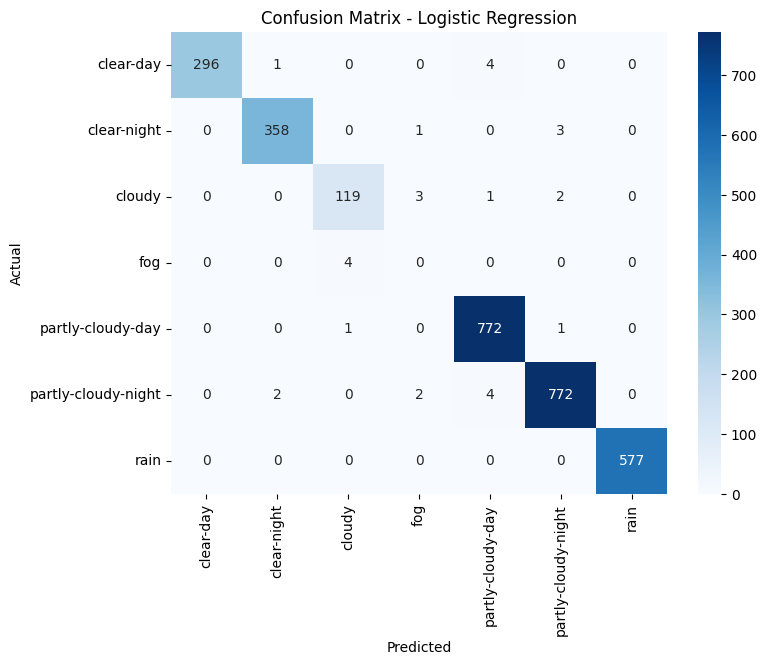

In [257]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [258]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [259]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [260]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 0.9972
cloudy   : 0.9768
fog      : 0.5075
partly-cloudy-day : 0.9996
partly-cloudy-night : 0.9973
rain     : 1.0000
Micro-avg : 0.9969


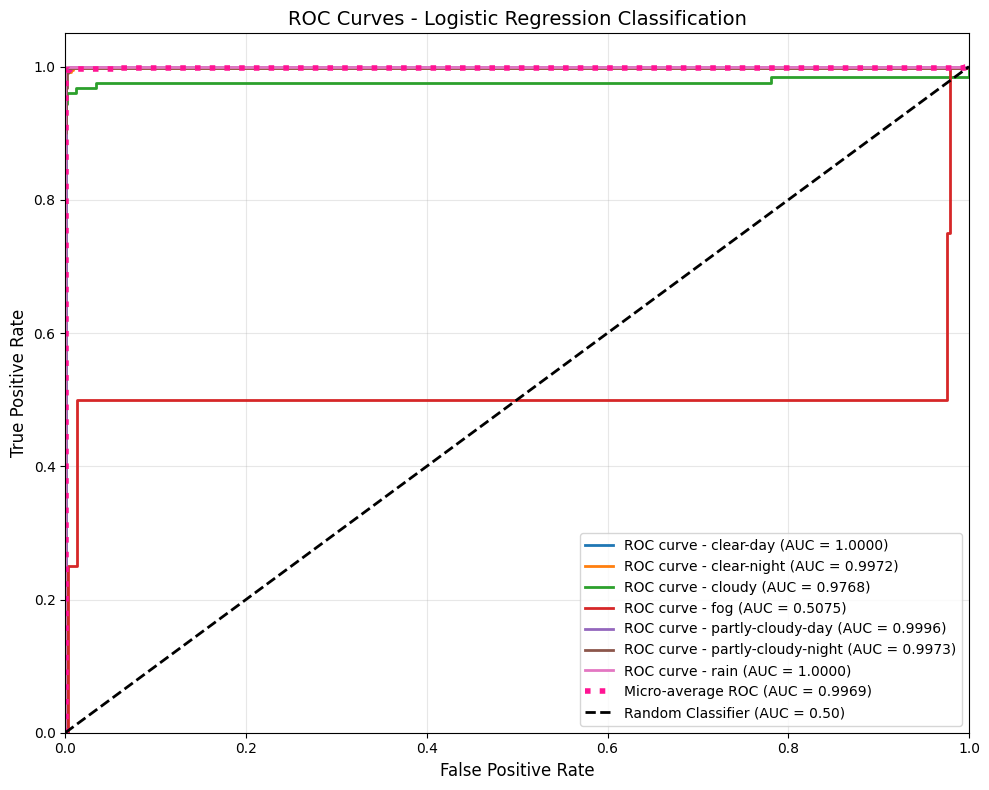

In [261]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [262]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9972
One-vs-One (Weighted)  : 0.9538
Micro-average          : 0.9969


In [263]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.651728 → 0.990079
   F1-Score: 0.641294 → 0.990410
   AUC (micro-avg): 0.801781 → 0.996875
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [264]:
grid_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass'), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_col_wise=True,
                                            objective='multiclass',
                                            random_state=42, verbose=0),
                   n_iter=350, n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.8, 0.9, 1.0],
                                        'bagging_freq': [0, 1, 5],
                                        'feature_fraction': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [-1, 3, 5, 7, 10],
                                        'min_child_samples': [20, 50, 100, 200],
                                        'min_child_weight': [0.001, 0.01, 0.1],
                                        'min_split_gain': [0.0, 0.1, 0.2],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [31, 50, 100, 150, 200],
                                        'reg_alpha': [0.0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0.0, 0.1, 0.5, 1.0],
                                        'subsample_for_bin': [200000, 300000,
                                                              500000]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [265]:
%%time
print("Starting Grid Search...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    grid_search.fit(X_train, y_train)

Starting Grid Search...
CPU times: total: 13 s
Wall time: 18min 23s


In [266]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'subsample_for_bin': 200000, 'reg_lambda': 0.5, 'reg_alpha': 1.0, 'num_leaves': 31, 'n_estimators': 300, 'min_split_gain': 0.0, 'min_child_weight': 0.01, 'min_child_samples': 50, 'max_depth': 3, 'learning_rate': 0.05, 'feature_fraction': 1.0, 'bagging_freq': 0, 'bagging_fraction': 0.8}
Best Cross-Validation Score: 0.9921949768462397


In [267]:
y_pred_grid = best_grid_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [268]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [269]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9925
Precision: 0.9912
Recall:    0.9925
F1-Score:  0.9918


In [270]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.99      0.99       301
        clear-night       1.00      0.99      0.99       362
             cloudy       0.96      0.98      0.97       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.99      1.00      0.99       774
partly-cloudy-night       0.99      0.99      0.99       780
               rain       1.00      1.00      1.00       577

           accuracy                           0.99      2923
          macro avg       0.85      0.85      0.85      2923
       weighted avg       0.99      0.99      0.99      2923



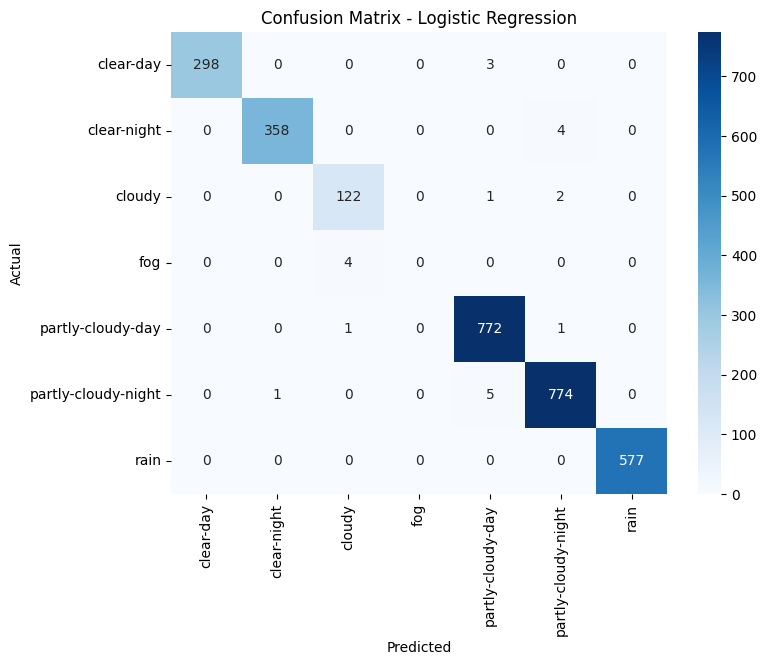

In [271]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [272]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


In [273]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [274]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 1.0000
clear-night : 1.0000
cloudy   : 0.9948
fog      : 0.9365
partly-cloudy-day : 0.9997
partly-cloudy-night : 0.9999
rain     : 1.0000
Micro-avg : 0.9994


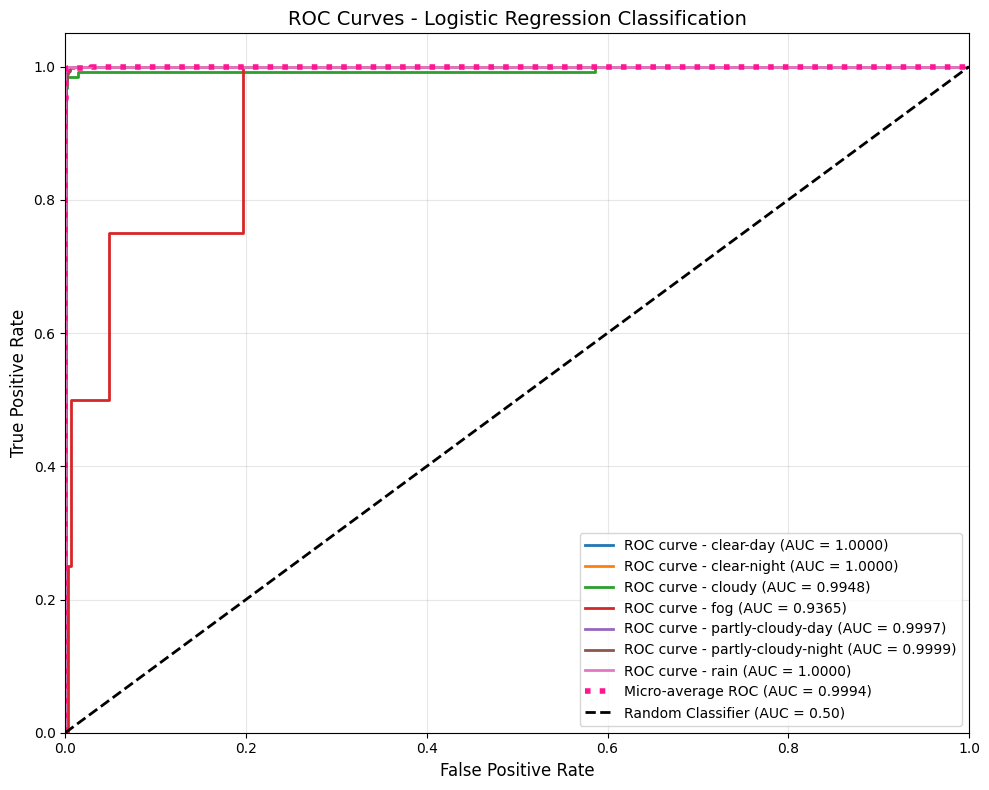

In [275]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [276]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9996
One-vs-One (Weighted)  : 0.9929
Micro-average          : 0.9994


In [277]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.989737 → 0.992473
   F1-Score: 0.989232 → 0.991804
   AUC (micro-avg): 0.999514 → 0.999432
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [278]:
base_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
base_model

LGBMClassifier(force_col_wise=True, objective='multiclass', random_state=42,
               verbose=0)

In [279]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=LGBMClassifier(force_col_wise=True,
                                           objective='multiclass',
                                           random_state=42, verbose=0),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [280]:
%%time
print("Starting Bagging Ensemble...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    bagging_clf.fit(X_train, y_train)

Starting Bagging Ensemble...
CPU times: total: 6 s
Wall time: 1min 24s


In [281]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.2s remaining:    9.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.2s finished


In [282]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [283]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9685
Precision: 0.9677
Recall:    0.9685
F1-Score:  0.9661


In [284]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          clear-day       1.00      0.93      0.96       301
        clear-night       0.99      0.97      0.98       362
             cloudy       0.95      0.61      0.74       125
                fog       0.00      0.00      0.00         4
  partly-cloudy-day       0.94      1.00      0.97       774
partly-cloudy-night       0.96      0.99      0.97       780
               rain       0.99      1.00      1.00       577

           accuracy                           0.97      2923
          macro avg       0.83      0.79      0.80      2923
       weighted avg       0.97      0.97      0.97      2923



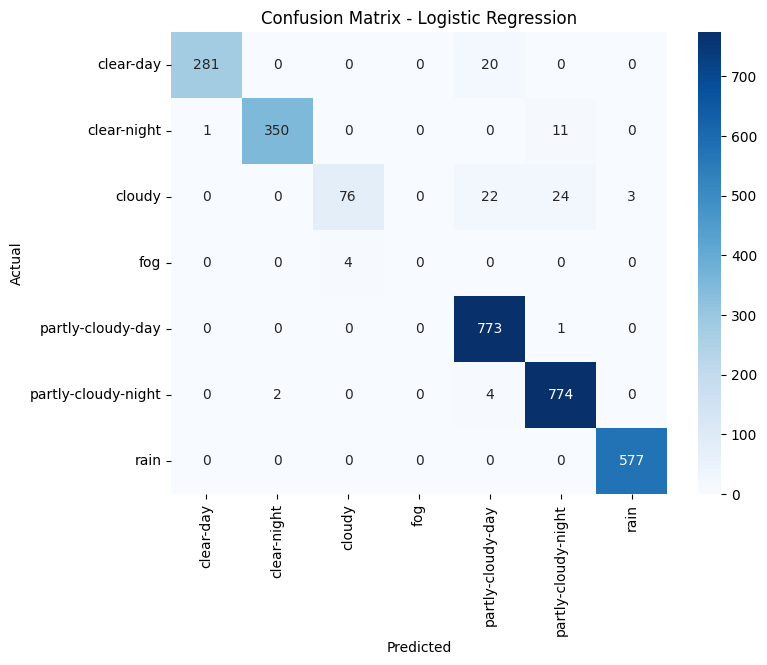

In [285]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [286]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.3s remaining:   10.0s


Classes: ['clear-day' 'clear-night' 'cloudy' 'fog' 'partly-cloudy-day'
 'partly-cloudy-night' 'rain']
Prediction probabilities shape: (2923, 7)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.8s finished


In [287]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [288]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
clear-day : 0.9989
clear-night : 0.9994
cloudy   : 0.9966
fog      : 0.9961
partly-cloudy-day : 0.9991
partly-cloudy-night : 0.9987
rain     : 1.0000
Micro-avg : 0.9987


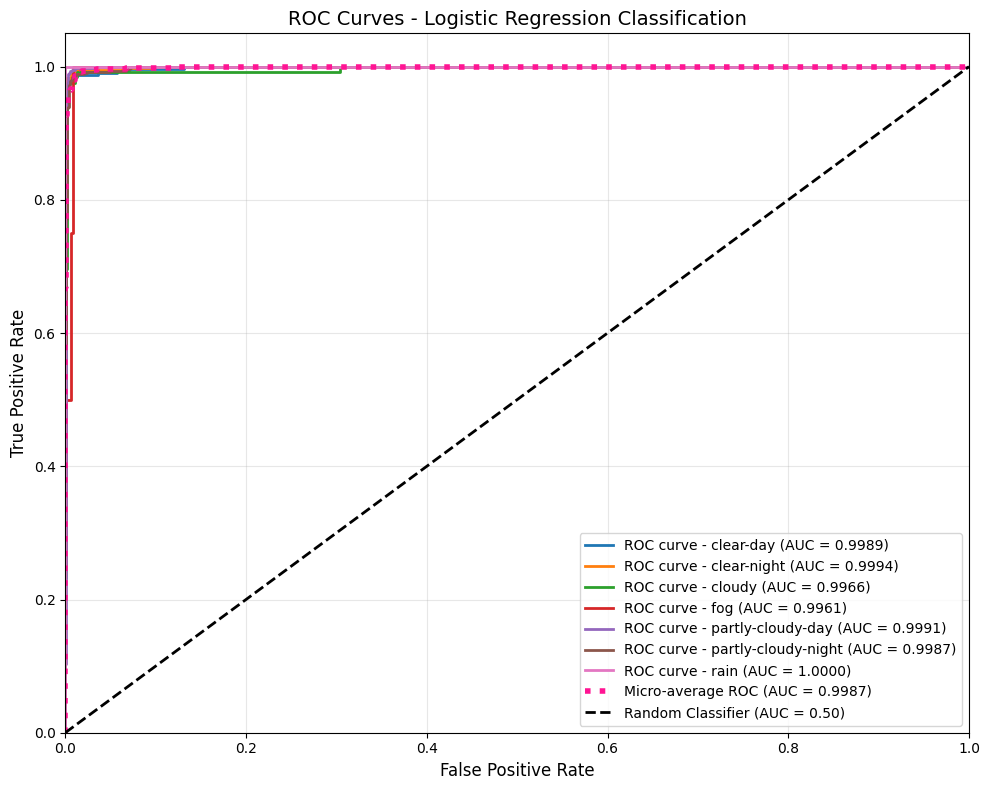

In [289]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [290]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9991
One-vs-One (Weighted)  : 0.9964
Micro-average          : 0.9987


In [291]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.968525, Best Accuracy: 0.988368
   Current F1: 0.966065, Best F1: 0.987673
   Current AUC (micro-avg): 0.998750, Best AUC: 0.999155
   Current Features: 23, Best Features: 27


# All Performance

In [292]:
show_model_history('classification', model_name=model_name_for_saving, target_column=target_name_for_saving)


📊 CLASSIFICATION Model Performance History
            Model         Scaler Target  Features Accuracy Precision   Recall F1-Score
   Light GBM Grid StandardScaler   Icon        23 0.993158  0.991848 0.993158 0.992490
   Light GBM Grid   RobustScaler   Icon        23 0.992473  0.991160 0.992473 0.991804
        Light GBM   MinMaxScaler   Icon        23 0.991789  0.990501 0.991789 0.991120
   Light GBM Grid   MinMaxScaler   Icon        23 0.991105  0.989823 0.991105 0.990435
        Light GBM   RobustScaler   Icon        23 0.990079  0.990769 0.990079 0.990410
        Light GBM StandardScaler   Icon        27 0.988710  0.989415 0.988710 0.989040
Light GBM Bagging   MinMaxScaler   Icon        27 0.989052  0.987789 0.989052 0.988371
Light GBM Bagging   RobustScaler   Icon        27 0.988368  0.987079 0.988368 0.987673
Light GBM Bagging StandardScaler   Icon        23 0.982552  0.981256 0.982552 0.981645

📈 Total models shown: 9
🏆 Best F1-Score: 0.992490 (Light GBM Grid + StandardScaler fo

# <center><font size="50" color="red">Thank You</font></center>